<a href="https://colab.research.google.com/github/inayatarshad/3D-Molecular-AR/blob/master/2k23_dataegt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
.import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pickle
import os

# --- 1. Load and Preprocess Data ---

# Load the datasets
try:
    normal_data = pd.read_csv('2024-05-06-SMKO56-SN9091-15.2.0.4389-USER_LOG_DATA.csv')

    print(f"Normal data loaded: {normal_data.shape}")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the CSV files are in the correct directory.")
    exit()

# Define EGT columns
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
time_col = 'Session Time'

# Ensure 'Session Time' is numeric for filtering
normal_data[time_col] = pd.to_numeric(normal_data[time_col], errors='coerce')

# Check which EGT columns exist in the data
available_egt_cols = [col for col in egt_cols if col in normal_data.columns]
print(f"Available EGT columns: {available_egt_cols}")

# Drop rows with NaN in EGT columns or Session Time
normal_data.dropna(subset=available_egt_cols + [time_col], inplace=True)

print(f"After cleaning - Normal data: {normal_data.shape}")

# Select only EGT columns for training and testing
normal_egt_data = normal_data[available_egt_cols].values

# Normalize the data
scaler = MinMaxScaler()
normal_egt_scaled = scaler.fit_transform(normal_egt_data)# Use the same scaler fitted on normal data

print(f"Data normalized. Normal shape: {normal_egt_scaled.shape}")

Normal data loaded: (1948, 102)
Available EGT columns: ['EGT 1 (deg C)', 'EGT 2 (deg C)', 'EGT 3 (deg C)', 'EGT 4 (deg C)', 'EGT 5 (deg C)', 'EGT 6 (deg C)']
After cleaning - Normal data: (1940, 102)
Data normalized. Normal shape: (1940, 6)


In [ ]:
# --- 2. Prepare Data for LSTM ---

TIME_STEPS = 10 # Define the sequence length for LSTM

def create_sequences(data, time_steps):
    """
    Creates sequences from the input data for LSTM.
    Each sequence will have `time_steps` number of observations.
    """
    X = []
    for i in range(len(data) - time_steps + 1):
        X.append(data[i:(i + time_steps)])
    return np.array(X)

X_train = create_sequences(normal_egt_scaled, TIME_STEPS)

print(f"Sequences created - Training: {X_train.shape}")

# --- 3. Build and Train LSTM Autoencoder Model ---

# Define the LSTM Autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_train.shape[1]), # Repeat the output to match the input sequence length
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2])) # Output layer to match the number of features
])

model.compile(optimizer='adam', loss='mae') # Using Mean Absolute Error as loss

print("\nTraining the LSTM autoencoder on normal data...")
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    verbose=1
)
print("Training complete.")

# --- 4. Save the Model and Scaler ---

# Create a directory for saving models in Google Drive
model_dir = '/content/drive/MyDrive/Python/saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(model_dir, 'lstm_autoencoder_model.h5')
model.save(model_path)
print(f"Model saved to: {model_path}")

# Save the scaler (important for preprocessing new data)
scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to: {scaler_path}")

# Save model configuration and parameters
config_path = os.path.join(model_dir, 'model_config.pkl')
model_config = {
    'TIME_STEPS': TIME_STEPS,
    'available_egt_cols': available_egt_cols,
    'input_shape': X_train.shape,
    'training_data_shape': normal_data.shape,
    'feature_columns': available_egt_cols
}
with open(config_path, 'wb') as f:
    pickle.dump(model_config, f)
print(f"Model configuration saved to: {config_path}")

# Save training history
history_path = os.path.join(model_dir, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved to: {history_path}")

print(f"\nAll files saved successfully to Google Drive at: {model_dir}")

Sequences created - Training: (1931, 10, 6)

Training the LSTM autoencoder on normal data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.5300 - val_loss: 0.1661
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0999 - val_loss: 0.0380
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0195 - val_loss: 0.0289
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0175 - val_loss: 0.0279
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0115 - val_loss: 0.0242
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0110 - val_loss: 0.0260
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0099 - val_loss: 0.0258
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0115 - val_loss: 0.0256
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0110 - val_loss: 0.0258
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0083 - val_loss: 0.0261


Training complete.
Model saved to: /content/drive/MyDrive/Python/saved_models/lstm_autoencoder_model.h5
Scaler saved to: /content/drive/MyDrive/Python/saved_models/scaler.pkl
Model configuration saved to: /content/drive/MyDrive/Python/saved_models/model_config.pkl
Training history saved to: /content/drive/MyDrive/Python/saved_models/training_history.pkl

All files saved successfully to Google Drive at: /content/drive/MyDrive/Python/saved_models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Python

/content/drive/MyDrive/Python


In [ ]:
import matplotlib.pyplot as plt

def create_egt_anomaly_graph(test_data, anomaly_details, available_egt_cols, threshold):
    fig = plt.figure(figsize=(20, 16))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Plot 1: All EGT channels with anomalies
    ax1 = plt.subplot(3, 1, 1)
    for i, col in enumerate(available_egt_cols):
        plt.plot(test_data['Session Time'], test_data[col],
                 color=colors[i % len(colors)], label=col, alpha=0.8, linewidth=2)

    if anomaly_details:
        channel_anomalies = {}
        for detail in anomaly_details:
            ch = detail['affected_channel']
            channel_anomalies.setdefault(ch, []).append(detail)

        for ch, anomalies in channel_anomalies.items():
            if ch in available_egt_cols:
                color = colors[available_egt_cols.index(ch) % len(colors)]
                timestamps = [a['timestamp'] for a in anomalies]
                temps = [a['actual_temperature'] for a in anomalies]
                plt.scatter(timestamps, temps, color='red', s=100, marker='x', zorder=10)
                for i, (t, temp) in enumerate(zip(timestamps, temps)):
                    plt.annotate(f'A{i+1}\n{t:.1f}s\n{temp:.1f}°C',
                                 xy=(t, temp), xytext=(10, 20), textcoords='offset points',
                                 bbox=dict(boxstyle='round', fc='yellow', alpha=0.7),
                                 arrowprops=dict(arrowstyle='->'), fontsize=8)

    plt.title('EGT Channels with Anomaly Detection Results', fontsize=16, fontweight='bold')
    plt.xlabel('Session Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 2: EGT 4
    if 'EGT 4 (deg C)' in available_egt_cols:
        ax2 = plt.subplot(3, 1, 2)
        plt.plot(test_data['Session Time'], test_data['EGT 4 (deg C)'],
                 color='#d62728', label='EGT 4', linewidth=2)
        egt4_anomalies = [a for a in anomaly_details if a['affected_channel'] == 'EGT 4 (deg C)']
        if egt4_anomalies:
            ts = [a['timestamp'] for a in egt4_anomalies]
            tmps = [a['actual_temperature'] for a in egt4_anomalies]
            plt.scatter(ts, tmps, color='red', s=150, marker='o', zorder=10)
            for i, (t, temp) in enumerate(zip(ts, tmps)):
                plt.annotate(f'EGT4-A{i+1}\n{t:.1f}s\n{temp:.1f}°C',
                             xy=(t, temp), xytext=(15, 25), textcoords='offset points',
                             bbox=dict(boxstyle='round', fc='orange', alpha=0.8),
                             arrowprops=dict(arrowstyle='->'), fontsize=9)

        plt.title('EGT 4 Channel - Detailed Anomaly Analysis', fontsize=14)
        plt.xlabel('Session Time (s)')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 3: Anomaly timeline
    ax3 = plt.subplot(3, 1, 3)
    if anomaly_details:
        ts = [d['timestamp'] for d in anomaly_details]
        chans = [d['affected_channel'].replace(' (deg C)', '') for d in anomaly_details]
        errors = [d['overall_error'] for d in anomaly_details]

        unique_chans = list(set(chans))
        y_map = {ch: i for i, ch in enumerate(unique_chans)}
        y_vals = [y_map[ch] for ch in chans]
        sizes = [(err / max(errors)) * 200 + 50 for err in errors]

        scatter = plt.scatter(ts, y_vals, s=sizes, c=errors, cmap='Reds', edgecolors='black', linewidth=1)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Reconstruction Error')

        for i, (t, yv) in enumerate(zip(ts, y_vals)):
            plt.annotate(f'A{i+1}\n{t:.1f}s', xy=(t, yv), xytext=(0, 15), textcoords='offset points',
                         bbox=dict(boxstyle='round', fc='white', alpha=0.8), fontsize=8, ha='center')

        plt.yticks(range(len(unique_chans)), unique_chans)
        plt.title('Anomaly Timeline by Channel', fontsize=14)
        plt.xlabel('Session Time (s)')
        plt.ylabel('EGT Channel')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center',
                 transform=ax3.transAxes, fontsize=14, bbox=dict(boxstyle='round', fc='lightblue'))

    # Summary box
    plt.figtext(0.02, 0.02, f"""
    ANOMALY DETECTION SUMMARY:
    • Total anomalies detected: {len(anomaly_details)}
    • Detection threshold: {threshold:.2f}
    • Time range: {test_data['Session Time'].min():.1f}s - {test_data['Session Time'].max():.1f}s
    • Channels monitored: {len(available_egt_cols)}
    """, fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()
    return fig


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Anomaly detection threshold (99th percentile of training MAE): 0.056965
Anomaly threshold saved to: saved_models/anomaly_threshold.pkl

Testing on full test dataset...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Total sequences in test data: 1931
Anomalies detected: 204
Anomaly detection rate: 10.56%

=== DETAILED ANOMALY ANALYSIS ===
Analyzing 204 detected anomalies...
Anomaly results saved to: saved_models/anomaly_results.pkl

=== ANOMALY DETECTION REPORT ===
Model trained on normal data shape: (1940, 102)
Model tested on full test data shape: (1940, 102)
Anomaly threshold: 0.056965
Total anomalies detected: 204

Detailed anomaly breakdown:

Anomalies by channel:
  EGT 2 (deg C): 1 anomalies
  EGT 3 (deg C): 10 anomalies
  EGT 4 (deg C): 184 anomalies
  EGT 5 (deg C): 7 anomalies
  EGT 6 (deg C): 2 anomalies

First 10 anomalies detected:
  Anomaly #1:
    Timestamp: 0.56s
    Affected Channel: EGT 2 (deg C)
    Temperature: 20.00°C
    Channel Erro

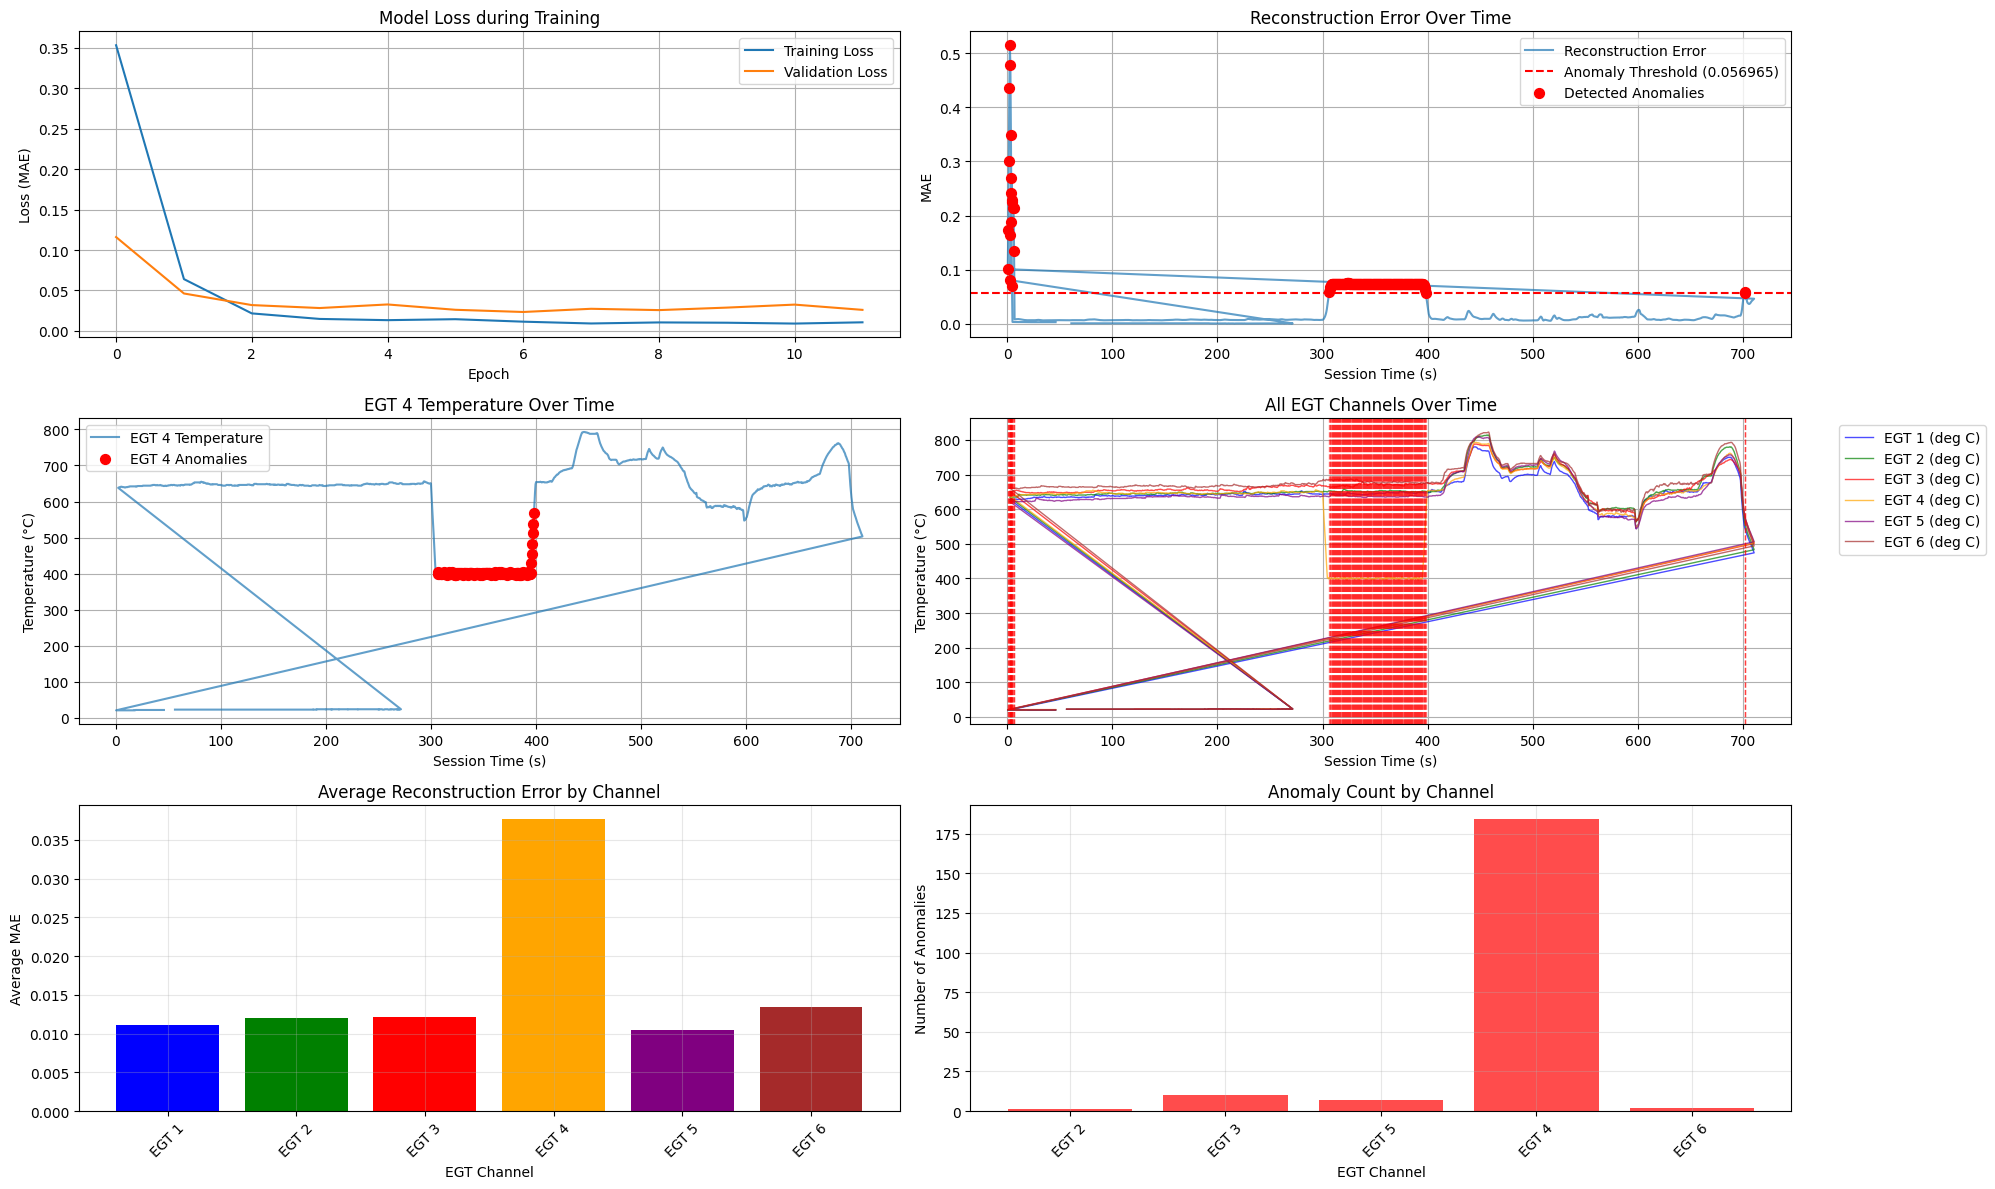

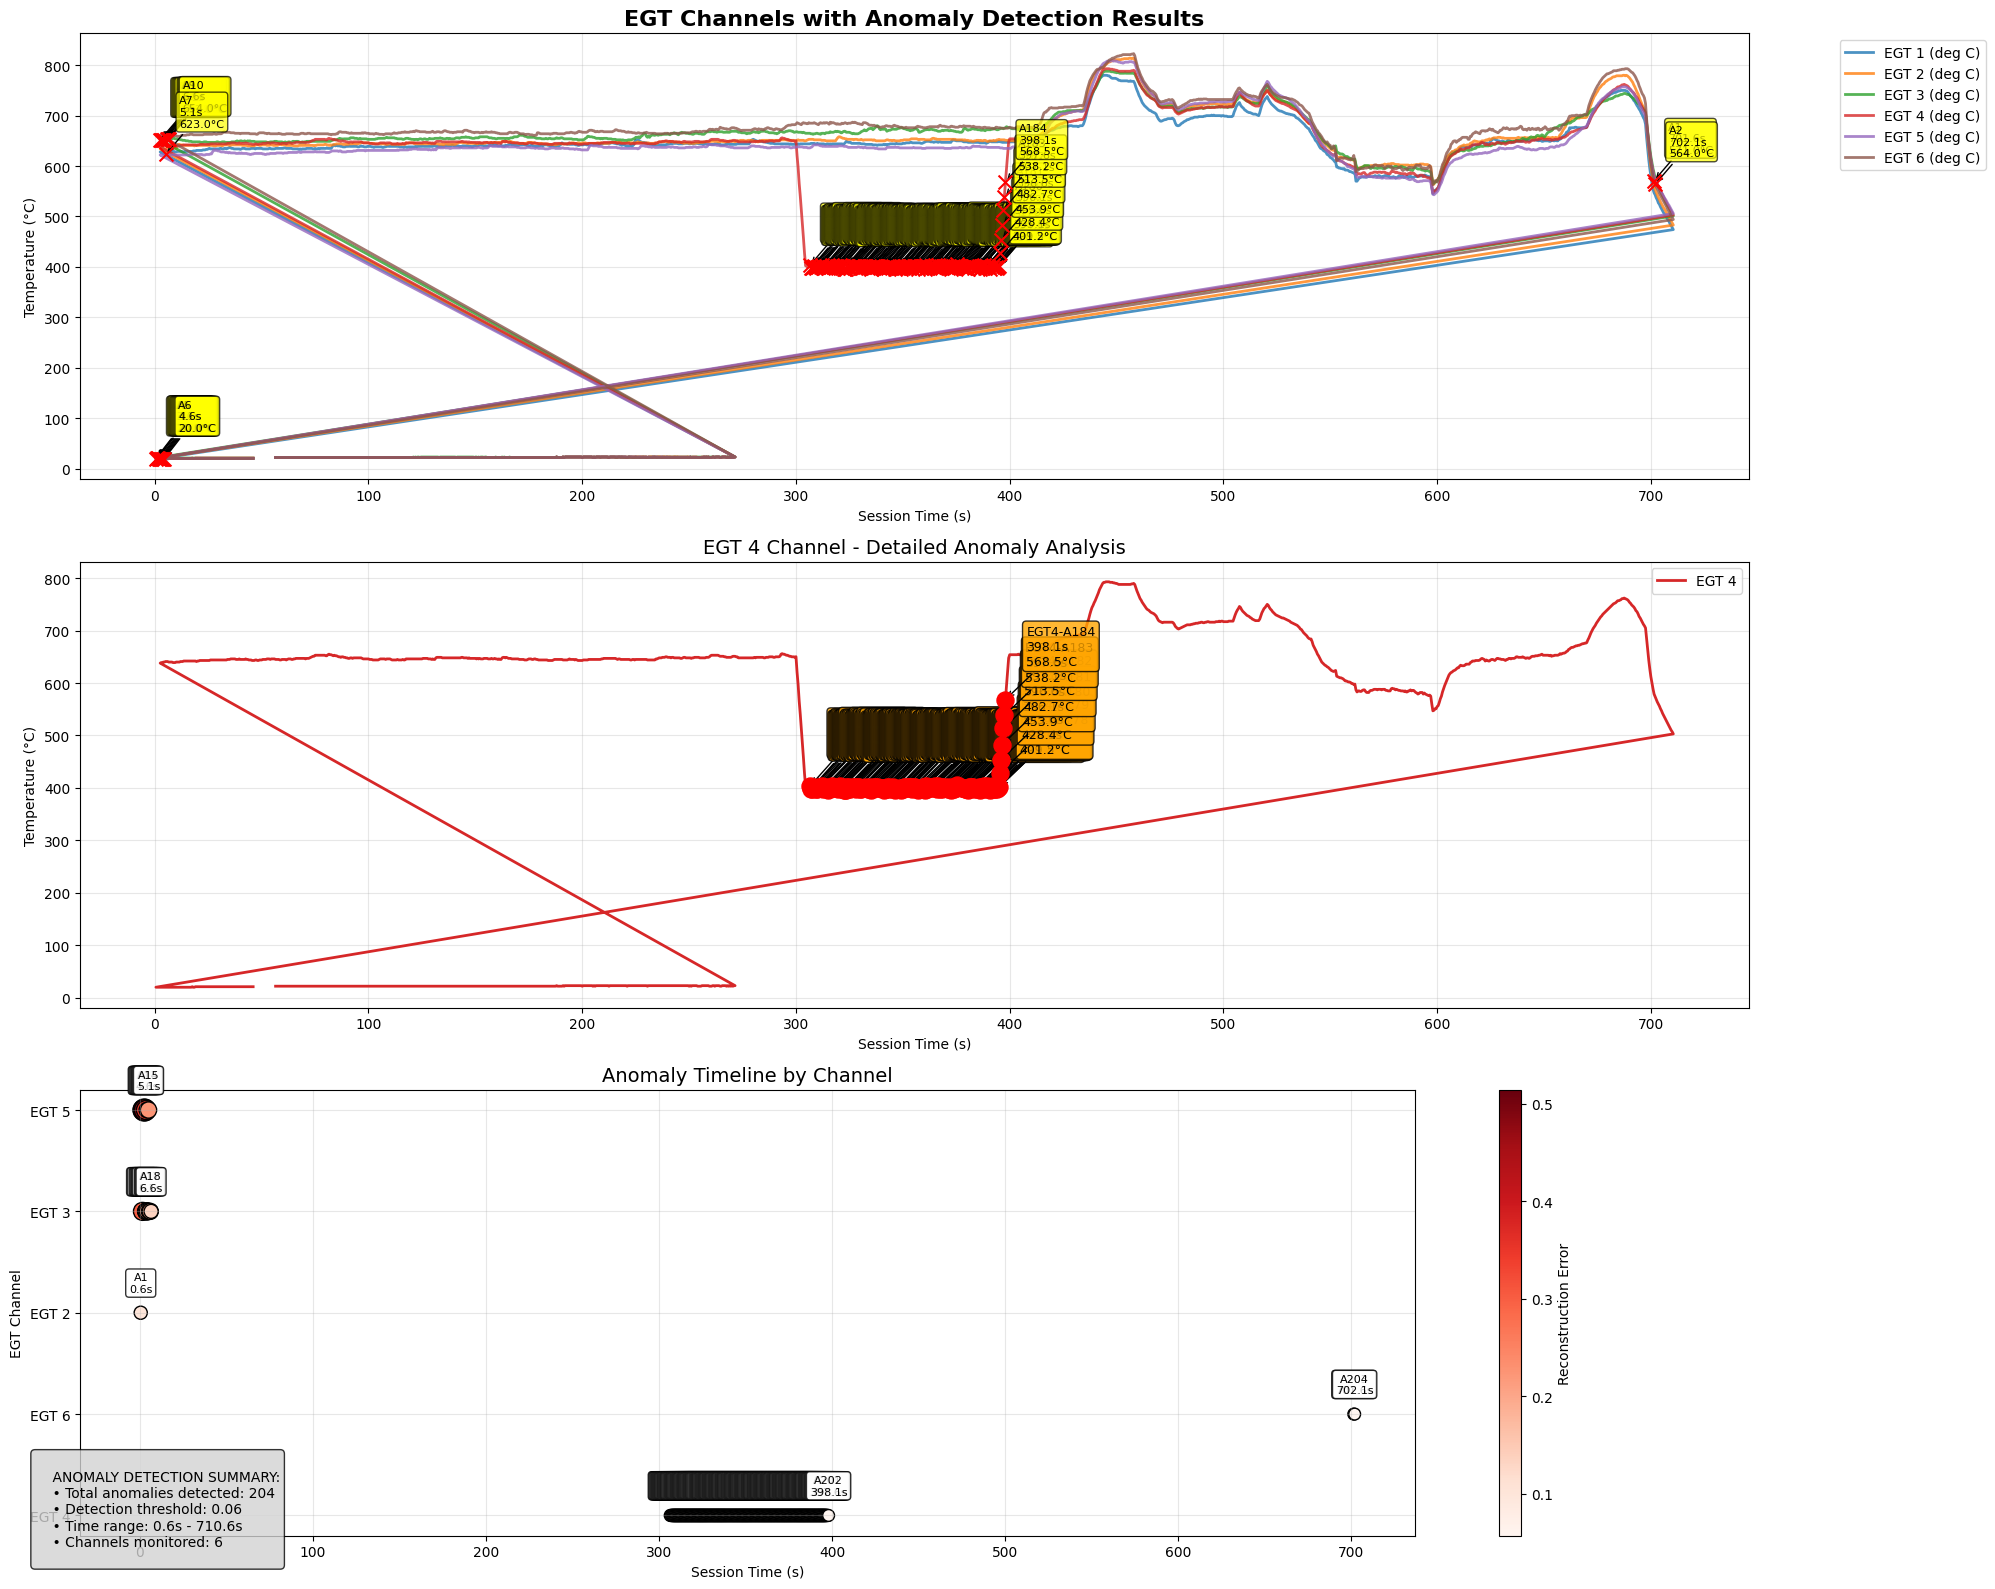


=== FINAL SUMMARY ===
Model successfully trained on normal data and tested on full test dataset.
The model learned normal EGT patterns and identified 204 anomalies.
EGT 4 anomalies detected: 184 out of 204 total anomalies.
EGT 4 detection accuracy: 90.2%

=== SAVED FILES ===
All model files have been saved to the 'saved_models' directory:
- Model: saved_models/lstm_autoencoder_model.h5
- Scaler: saved_models/scaler.pkl
- Configuration: saved_models/model_config.pkl
- Training history: saved_models/training_history.pkl
- Anomaly threshold: saved_models/anomaly_threshold.pkl
- Anomaly results: saved_models/anomaly_results.pkl


In [ ]:
# --- 5. Anomaly Detection on Full Test Data ---

# Get predictions for training data to establish baseline
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train - X_train_pred), axis=(1, 2))

# Set threshold for anomaly detection (99th percentile of training reconstruction errors)
THRESHOLD = np.percentile(train_mae_loss, 99)
print(f"\nAnomaly detection threshold (99th percentile of training MAE): {THRESHOLD:.6f}")

# Save the threshold
threshold_path = os.path.join(model_dir, 'anomaly_threshold.pkl')
with open(threshold_path, 'wb') as f:
    pickle.dump(THRESHOLD, f)
print(f"Anomaly threshold saved to: {threshold_path}")

# Get predictions for ALL test data
print("\nTesting on full test dataset...")
X_test_pred = model.predict(X_test)

# Calculate overall reconstruction error for each sequence
test_mae_loss = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

# Calculate per-channel reconstruction errors for detailed analysis
per_channel_errors = np.mean(np.abs(X_test - X_test_pred), axis=1)  # Shape: (num_sequences, num_channels)

# Identify anomalies based on overall reconstruction error
anomalies = test_mae_loss > THRESHOLD

print(f"Total sequences in test data: {len(test_mae_loss)}")
print(f"Anomalies detected: {np.sum(anomalies)}")
print(f"Anomaly detection rate: {np.sum(anomalies)/len(test_mae_loss)*100:.2f}%")

# --- 6. Detailed Anomaly Analysis ---

# Create results DataFrame aligned with original test data
test_results = test_data.iloc[TIME_STEPS - 1:].copy().reset_index(drop=True)
test_results['MAE_Loss'] = test_mae_loss
test_results['Is_Anomaly'] = anomalies

# Add per-channel error information
for i, col in enumerate(available_egt_cols):
    test_results[f'{col}_Error'] = per_channel_errors[:, i]

# Find anomalies and identify which channel has the highest error
anomaly_details = []
anomaly_indices = np.where(anomalies)[0]

print(f"\n=== DETAILED ANOMALY ANALYSIS ===")
print(f"Analyzing {len(anomaly_indices)} detected anomalies...")

for idx in anomaly_indices:
    # Get the original data index
    original_idx = idx + TIME_STEPS - 1

    if original_idx < len(test_data):
        timestamp = test_results.iloc[idx]['Session Time']
        overall_error = test_mae_loss[idx]

        # Find which channel has the highest reconstruction error
        channel_errors = per_channel_errors[idx]
        max_error_channel_idx = np.argmax(channel_errors)
        max_error_channel = available_egt_cols[max_error_channel_idx]
        max_error_value = channel_errors[max_error_channel_idx]

        # Get actual temperature value
        actual_temp = test_data.iloc[original_idx][max_error_channel]

        anomaly_details.append({
            'sequence_idx': idx,
            'timestamp': timestamp,
            'overall_error': overall_error,
            'affected_channel': max_error_channel,
            'channel_error': max_error_value,
            'actual_temperature': actual_temp
        })

# Sort anomalies by timestamp
anomaly_details.sort(key=lambda x: x['timestamp'])

# Save anomaly results
results_path = os.path.join(model_dir, 'anomaly_results.pkl')
results_data = {
    'anomaly_details': anomaly_details,
    'test_results': test_results,
    'threshold': THRESHOLD,
    'total_anomalies': len(anomaly_details)
}
with open(results_path, 'wb') as f:
    pickle.dump(results_data, f)
print(f"Anomaly results saved to: {results_path}")

# Print detailed anomaly report
print(f"\n=== ANOMALY DETECTION REPORT ===")
print(f"Model trained on normal data shape: {normal_data.shape}")
print(f"Model tested on full test data shape: {test_data.shape}")
print(f"Anomaly threshold: {THRESHOLD:.6f}")
print(f"Total anomalies detected: {len(anomaly_details)}")

if anomaly_details:
    print(f"\nDetailed anomaly breakdown:")

    # Group by affected channel
    channel_counts = {}
    for detail in anomaly_details:
        channel = detail['affected_channel']
        channel_counts[channel] = channel_counts.get(channel, 0) + 1

    print(f"\nAnomalies by channel:")
    for channel, count in sorted(channel_counts.items()):
        print(f"  {channel}: {count} anomalies")

    print(f"\nFirst 10 anomalies detected:")
    for i, detail in enumerate(anomaly_details[:10]):
        print(f"  Anomaly #{i+1}:")
        print(f"    Timestamp: {detail['timestamp']:.2f}s")
        print(f"    Affected Channel: {detail['affected_channel']}")
        print(f"    Temperature: {detail['actual_temperature']:.2f}°C")
        print(f"    Channel Error: {detail['channel_error']:.6f}")
        print(f"    Overall Error: {detail['overall_error']:.6f}")
        print()

    # Focus on EGT 4 anomalies if detected
    if 'EGT 4 (deg C)' in available_egt_cols:
        egt4_anomalies = [d for d in anomaly_details if d['affected_channel'] == 'EGT 4 (deg C)']
        print(f"\n=== EGT 4 SPECIFIC ANOMALIES ===")
        print(f"EGT 4 anomalies detected: {len(egt4_anomalies)}")

        if egt4_anomalies:
            print(f"EGT 4 anomaly timestamps:")
            for detail in egt4_anomalies:
                print(f"  {detail['timestamp']:.2f}s - Temp: {detail['actual_temperature']:.2f}°C - Error: {detail['channel_error']:.6f}")
else:
    print("No anomalies detected in the test data.")

# --- 7. Visualization ---

plt.figure(figsize=(20, 12))

# Plot 1: Training loss
plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)

# Plot 2: Reconstruction error over time
plt.subplot(3, 2, 2)
plt.plot(test_results['Session Time'], test_mae_loss, label='Reconstruction Error', alpha=0.7)
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label=f'Anomaly Threshold ({THRESHOLD:.6f})')
if anomaly_details:
    anomaly_timestamps = [d['timestamp'] for d in anomaly_details]
    anomaly_errors = [d['overall_error'] for d in anomaly_details]
    plt.scatter(anomaly_timestamps, anomaly_errors, color='red', s=50, label='Detected Anomalies', zorder=5)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Session Time (s)')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot 3: EGT 4 temperature over time
if 'EGT 4 (deg C)' in available_egt_cols:
    plt.subplot(3, 2, 3)
    plt.plot(test_data['Session Time'], test_data['EGT 4 (deg C)'], label='EGT 4 Temperature', alpha=0.7)
    egt4_anomalies = [d for d in anomaly_details if d['affected_channel'] == 'EGT 4 (deg C)']
    if egt4_anomalies:
        egt4_timestamps = [d['timestamp'] for d in egt4_anomalies]
        egt4_temps = [d['actual_temperature'] for d in egt4_anomalies]
        plt.scatter(egt4_timestamps, egt4_temps, color='red', s=50, label='EGT 4 Anomalies', zorder=5)
    plt.title('EGT 4 Temperature Over Time')
    plt.xlabel('Session Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

# Plot 4: All EGT channels
plt.subplot(3, 2, 4)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
for i, col in enumerate(available_egt_cols):
    color = colors[i % len(colors)]
    plt.plot(test_data['Session Time'], test_data[col], color=color,
             label=col, alpha=0.7, linewidth=1)

# Highlight anomaly timestamps
if anomaly_details:
    anomaly_timestamps = [d['timestamp'] for d in anomaly_details]
    for timestamp in anomaly_timestamps:
        plt.axvline(x=timestamp, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.title('All EGT Channels Over Time')
plt.xlabel('Session Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 5: Per-channel error distribution
plt.subplot(3, 2, 5)
channel_mean_errors = np.mean(per_channel_errors, axis=0)
plt.bar(range(len(available_egt_cols)), channel_mean_errors,
        color=colors[:len(available_egt_cols)])
plt.title('Average Reconstruction Error by Channel')
plt.xlabel('EGT Channel')
plt.ylabel('Average MAE')
plt.xticks(range(len(available_egt_cols)),
           [col.replace(' (deg C)', '') for col in available_egt_cols], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Anomaly distribution by channel
plt.subplot(3, 2, 6)
if anomaly_details:
    channel_counts = {}
    for detail in anomaly_details:
        channel = detail['affected_channel'].replace(' (deg C)', '')
        channel_counts[channel] = channel_counts.get(channel, 0) + 1

    channels = list(channel_counts.keys())
    counts = list(channel_counts.values())

    plt.bar(channels, counts, color='red', alpha=0.7)
    plt.title('Anomaly Count by Channel')
    plt.xlabel('EGT Channel')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Anomaly Count by Channel')

plt.tight_layout()
plt.show()

create_egt_anomaly_graph(
    test_data=test_data,
    anomaly_details=anomaly_details,
    available_egt_cols=available_egt_cols,
    threshold=THRESHOLD
)
print(f"\n=== FINAL SUMMARY ===")
print(f"Model successfully trained on normal data and tested on full test dataset.")
print(f"The model learned normal EGT patterns and identified {len(anomaly_details)} anomalies.")
if 'EGT 4 (deg C)' in available_egt_cols:
    egt4_anomalies = [d for d in anomaly_details if d['affected_channel'] == 'EGT 4 (deg C)']
    print(f"EGT 4 anomalies detected: {len(egt4_anomalies)} out of {len(anomaly_details)} total anomalies.")
    if len(anomaly_details) > 0:
        print(f"EGT 4 detection accuracy: {len(egt4_anomalies)/len(anomaly_details)*100:.1f}%")

print(f"\n=== SAVED FILES ===")
print(f"All model files have been saved to the '{model_dir}' directory:")
print(f"- Model: {model_path}")
print(f"- Scaler: {scaler_path}")
print(f"- Configuration: {config_path}")
print(f"- Training history: {history_path}")
print(f"- Anomaly threshold: {threshold_path}")
print(f"- Anomaly results: {results_path}")

Loading pre-trained model and components...
❌ Error loading model components: Could not locate function 'mae'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mae', 'registered_name': 'mae'}

Loading new test data...
✓ New test data loaded: (124740, 103)
Available EGT columns: ['EGT 1 (deg C)', 'EGT 2 (deg C)', 'EGT 3 (deg C)', 'EGT 4 (deg C)', 'EGT 5 (deg C)', 'EGT 6 (deg C)']
Cleaning data...
Data cleaned: (124740, 103) → (124569, 103)
Data normalized: (124569, 6)

Creating sequences with 10 time steps...
Test sequences created: (124560, 10, 6)

Performing anomaly detection...
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step

=== ANOMALY DETECTION RESULTS ===
Total sequences analyzed: 124560
Anomalies detected: 862
Anomaly detection rate: 0.69%

Analyzing 862 detected anomalies...

=== STATISTICAL ANALYSIS ===
Reconstruction Error Statistics:
  Mean: 0.016033
  S

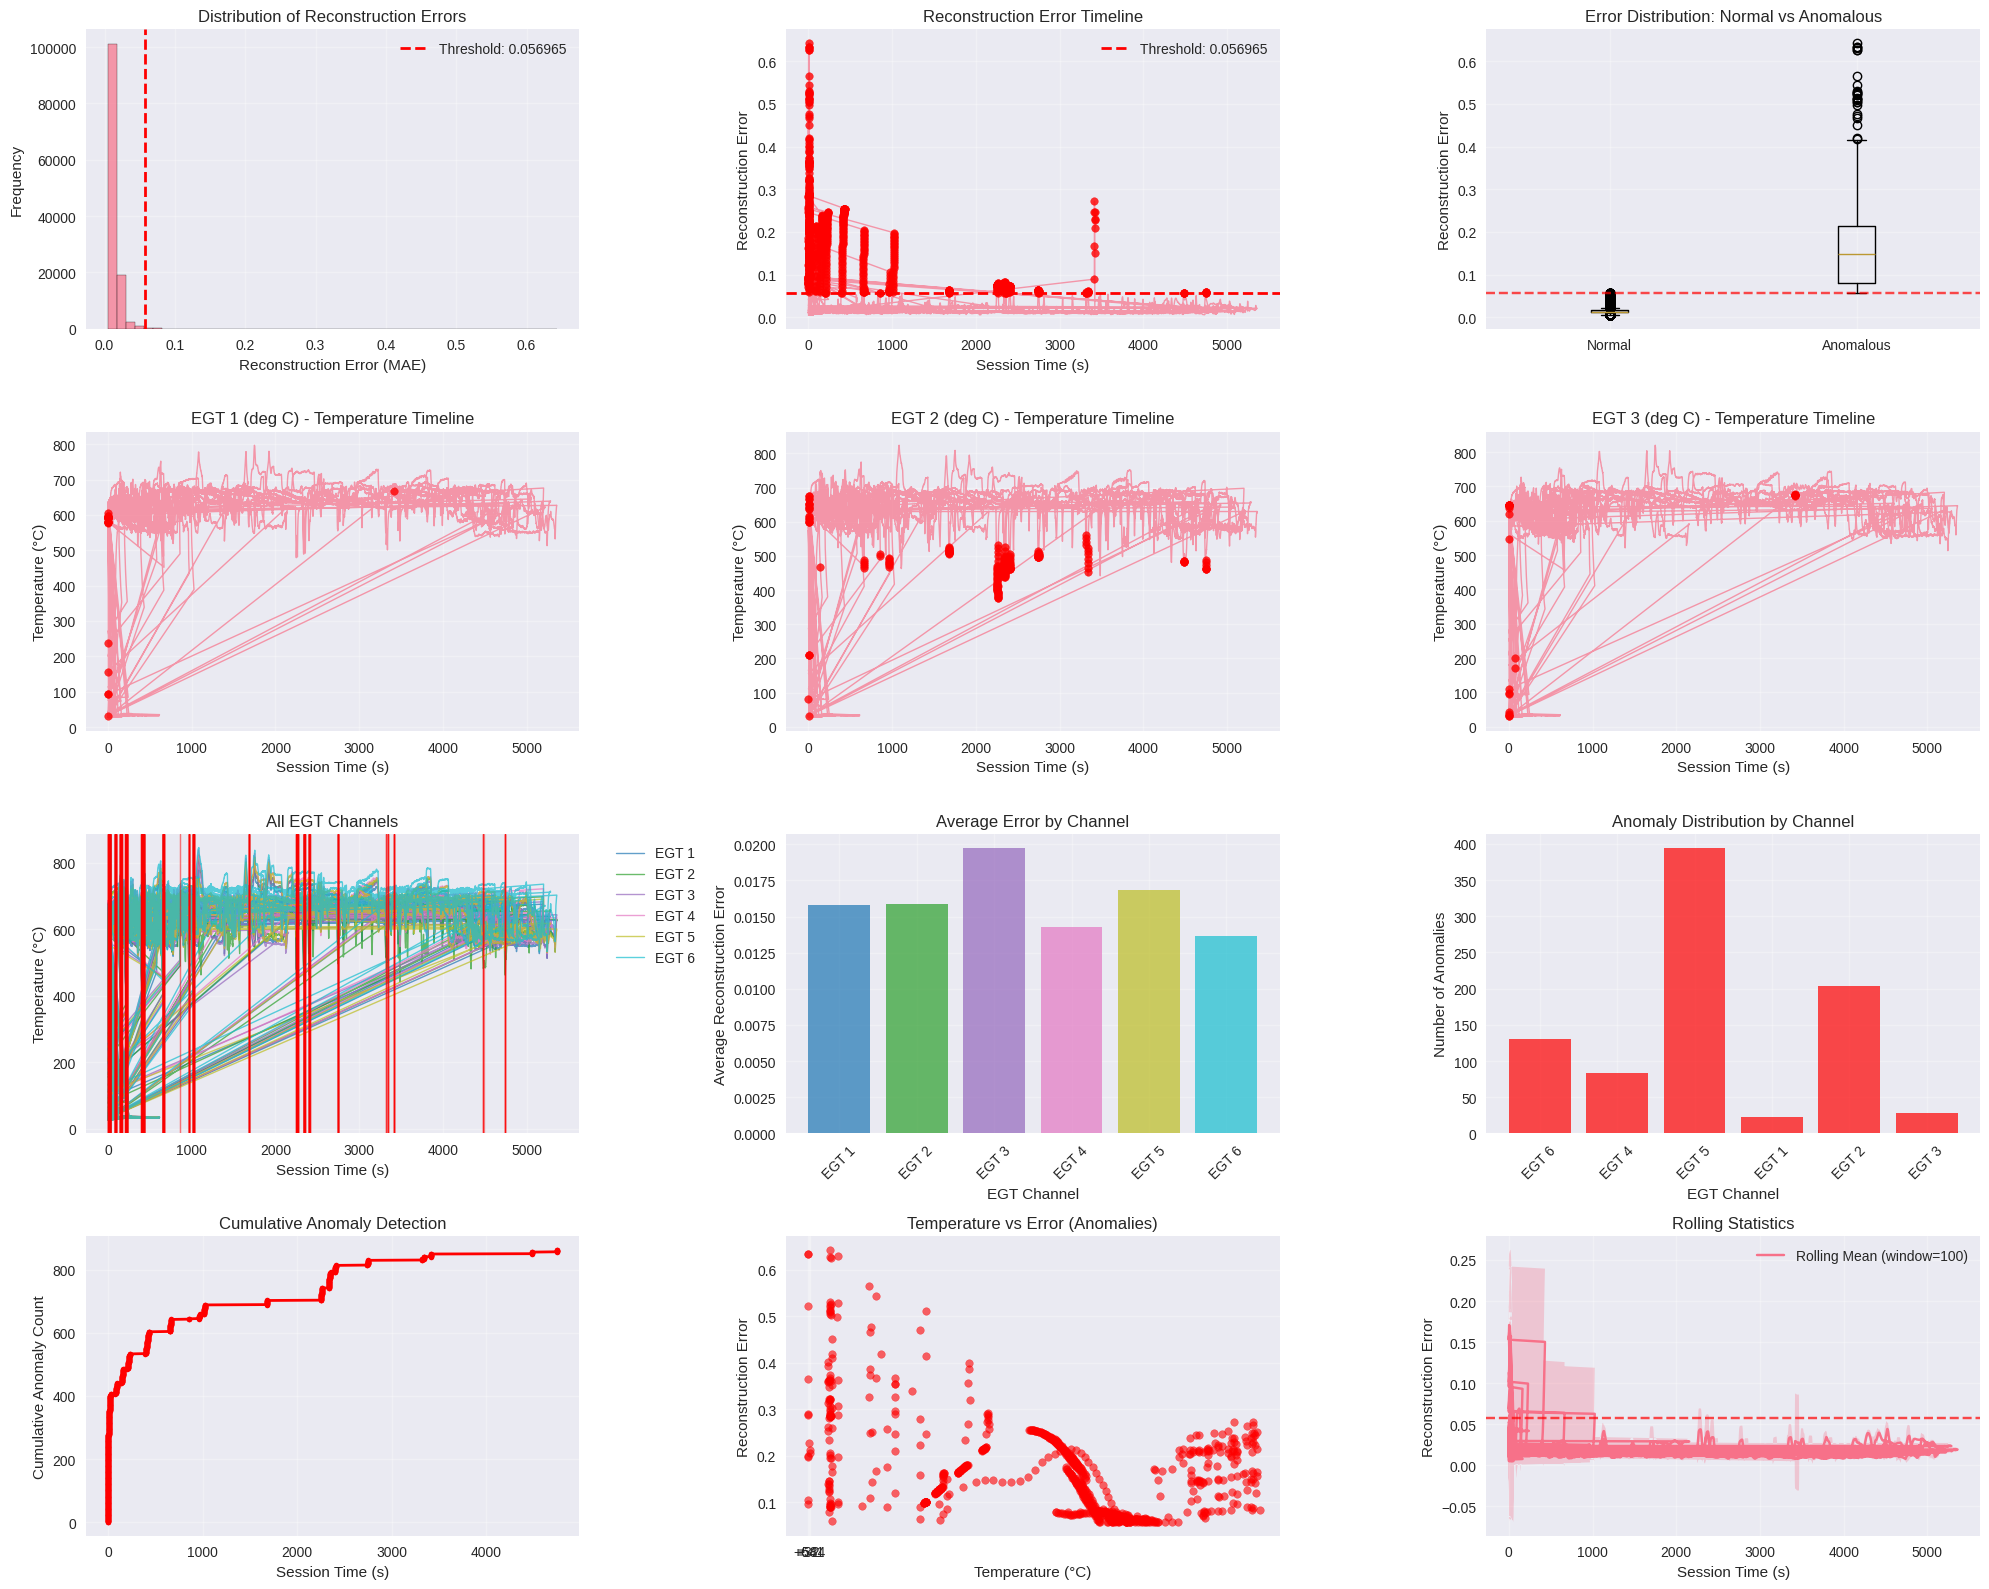


Saving results...
✓ Anomaly report saved to: test_results_20250710_054255/anomaly_report.csv
✓ Results saved to: test_results_20250710_054255/anomaly_detection_results.pkl

ANOMALY DETECTION TEST REPORT
Test File: 2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv
Model Threshold: 0.056965
Total Data Points: 124569
Total Sequences: 124560
Anomalies Detected: 862
Anomaly Rate: 0.69%

Error Statistics:
  Mean Error: 0.016033
  Threshold Exceeded: 862 times
  Max Error: 0.642939

Top 5 Anomalies:
  1. Time: 3.6s, Channel: EGT 4 (deg C), Error: 0.642939
  2. Time: 3.6s, Channel: EGT 6 (deg C), Error: 0.633439
  3. Time: 3.6s, Channel: EGT 6 (deg C), Error: 0.633292
  4. Time: 3.1s, Channel: EGT 4 (deg C), Error: 0.630066
  5. Time: 3.6s, Channel: EGT 6 (deg C), Error: 0.627265

Channel Analysis:
  EGT 5 (deg C): 394 anomalies (45.7%)
  EGT 2 (deg C): 204 anomalies (23.7%)
  EGT 6 (deg C): 131 anomalies (15.2%)
  EGT 4 (deg C): 83 anomalies (9.6%)
  EGT 3 (deg C): 28 anomalies (3.2%)
 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- 1. Load Pre-trained Model and Components ---

model_dir = 'saved_models'  # Adjust path as needed

print("Loading pre-trained model and components...")
try:
    # Load model
    model_path = os.path.join(model_dir, 'lstm_autoencoder_model.h5')
    model = load_model(model_path)
    print(f"✓ Model loaded from: {model_path}")

    # Load scaler
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler loaded from: {scaler_path}")

    # Load threshold
    threshold_path = os.path.join(model_dir, 'anomaly_threshold.pkl')
    with open(threshold_path, 'rb') as f:
        THRESHOLD = pickle.load(f)
    print(f"✓ Anomaly threshold loaded: {THRESHOLD:.6f}")

    # Load configuration
    config_path = os.path.join(model_dir, 'model_config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    TIME_STEPS = config['TIME_STEPS']
    print(f"✓ Configuration loaded - Time steps: {TIME_STEPS}")

except Exception as e:
    print(f"❌ Error loading model components: {e}")
    exit()

# --- 2. Load and Preprocess New Test Data ---

print("\nLoading new test data...")
try:
    # Load the new test dataset
    new_test_data = pd.read_csv('2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv')
    print(f"✓ New test data loaded: {new_test_data.shape}")
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}")
    exit()

# Define EGT columns
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
time_col = 'Session Time'

# Ensure 'Session Time' is numeric
new_test_data[time_col] = pd.to_numeric(new_test_data[time_col], errors='coerce')

# Check which EGT columns exist
available_egt_cols = [col for col in egt_cols if col in new_test_data.columns]
print(f"Available EGT columns: {available_egt_cols}")

# Clean data
print("Cleaning data...")
initial_shape = new_test_data.shape
new_test_data.dropna(subset=available_egt_cols + [time_col], inplace=True)
print(f"Data cleaned: {initial_shape} → {new_test_data.shape}")

# Select EGT data
new_test_egt_data = new_test_data[available_egt_cols].values

# Normalize using the pre-trained scaler
new_test_egt_scaled = scaler.transform(new_test_egt_data)
print(f"Data normalized: {new_test_egt_scaled.shape}")

# --- 3. Create Sequences for Testing ---

def create_sequences(data, time_steps):
    """Create sequences for LSTM input"""
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

print(f"\nCreating sequences with {TIME_STEPS} time steps...")
X_new_test = create_sequences(new_test_egt_scaled, TIME_STEPS)
print(f"Test sequences created: {X_new_test.shape}")

# --- 4. Perform Anomaly Detection ---

print("\nPerforming anomaly detection...")

# Get predictions
X_new_test_pred = model.predict(X_new_test, verbose=1)

# Calculate reconstruction errors
test_mae_loss = np.mean(np.abs(X_new_test - X_new_test_pred), axis=(1, 2))

# Calculate per-channel reconstruction errors
per_channel_errors = np.mean(np.abs(X_new_test - X_new_test_pred), axis=1)

# Identify anomalies
anomalies = test_mae_loss > THRESHOLD

print(f"\n=== ANOMALY DETECTION RESULTS ===")
print(f"Total sequences analyzed: {len(test_mae_loss)}")
print(f"Anomalies detected: {np.sum(anomalies)}")
print(f"Anomaly detection rate: {np.sum(anomalies)/len(test_mae_loss)*100:.2f}%")

# --- 5. Detailed Analysis ---

# Create results DataFrame
test_results = new_test_data.iloc[TIME_STEPS - 1:].copy().reset_index(drop=True)
test_results['MAE_Loss'] = test_mae_loss
test_results['Is_Anomaly'] = anomalies

# Add per-channel error information
for i, col in enumerate(available_egt_cols):
    test_results[f'{col}_Error'] = per_channel_errors[:, i]

# Analyze anomaly details
anomaly_details = []
anomaly_indices = np.where(anomalies)[0]

print(f"\nAnalyzing {len(anomaly_indices)} detected anomalies...")

for idx in anomaly_indices:
    original_idx = idx + TIME_STEPS - 1

    if original_idx < len(new_test_data):
        timestamp = test_results.iloc[idx]['Session Time']
        overall_error = test_mae_loss[idx]

        # Find channel with highest error
        channel_errors = per_channel_errors[idx]
        max_error_channel_idx = np.argmax(channel_errors)
        max_error_channel = available_egt_cols[max_error_channel_idx]
        max_error_value = channel_errors[max_error_channel_idx]

        # Get actual temperature
        actual_temp = new_test_data.iloc[original_idx][max_error_channel]

        anomaly_details.append({
            'sequence_idx': idx,
            'timestamp': timestamp,
            'overall_error': overall_error,
            'affected_channel': max_error_channel,
            'channel_error': max_error_value,
            'actual_temperature': actual_temp
        })

# Sort by timestamp
anomaly_details.sort(key=lambda x: x['timestamp'])

# --- 6. Statistical Analysis ---

print(f"\n=== STATISTICAL ANALYSIS ===")
print(f"Reconstruction Error Statistics:")
print(f"  Mean: {np.mean(test_mae_loss):.6f}")
print(f"  Std:  {np.std(test_mae_loss):.6f}")
print(f"  Min:  {np.min(test_mae_loss):.6f}")
print(f"  Max:  {np.max(test_mae_loss):.6f}")
print(f"  Median: {np.median(test_mae_loss):.6f}")
print(f"  95th percentile: {np.percentile(test_mae_loss, 95):.6f}")
print(f"  99th percentile: {np.percentile(test_mae_loss, 99):.6f}")

# Channel-wise analysis
if anomaly_details:
    print(f"\nChannel-wise Anomaly Distribution:")
    channel_counts = {}
    for detail in anomaly_details:
        channel = detail['affected_channel']
        channel_counts[channel] = channel_counts.get(channel, 0) + 1

    for channel, count in sorted(channel_counts.items()):
        percentage = (count / len(anomaly_details)) * 100
        print(f"  {channel}: {count} anomalies ({percentage:.1f}%)")

# --- 7. Comprehensive Visualizations ---

print("\nGenerating visualizations...")

# Create a comprehensive figure
fig = plt.figure(figsize=(20, 16))

# Plot 1: Reconstruction Error Distribution
plt.subplot(4, 3, 1)
plt.hist(test_mae_loss, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {THRESHOLD:.6f}')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Reconstruction Error Over Time
plt.subplot(4, 3, 2)
plt.plot(test_results['Session Time'], test_mae_loss, alpha=0.7, linewidth=1)
plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {THRESHOLD:.6f}')
if anomaly_details:
    anomaly_timestamps = [d['timestamp'] for d in anomaly_details]
    anomaly_errors = [d['overall_error'] for d in anomaly_details]
    plt.scatter(anomaly_timestamps, anomaly_errors, color='red', s=30, alpha=0.8, zorder=5)
plt.xlabel('Session Time (s)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Timeline')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Box Plot of Reconstruction Errors
plt.subplot(4, 3, 3)
normal_errors = test_mae_loss[~anomalies]
anomaly_errors = test_mae_loss[anomalies] if np.any(anomalies) else []

box_data = [normal_errors]
labels = ['Normal']
if len(anomaly_errors) > 0:
    box_data.append(anomaly_errors)
    labels.append('Anomalous')

plt.boxplot(box_data, labels=labels)
plt.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.7)
plt.ylabel('Reconstruction Error')
plt.title('Error Distribution: Normal vs Anomalous')
plt.grid(True, alpha=0.3)

# Plot 4-6: Individual EGT Channel Analysis
for i, col in enumerate(available_egt_cols[:3]):  # Show first 3 channels
    plt.subplot(4, 3, 4 + i)
    plt.plot(new_test_data['Session Time'], new_test_data[col], alpha=0.7, linewidth=1)

    # Highlight anomalies for this channel
    if anomaly_details:
        channel_anomalies = [d for d in anomaly_details if d['affected_channel'] == col]
        if channel_anomalies:
            timestamps = [d['timestamp'] for d in channel_anomalies]
            temps = [d['actual_temperature'] for d in channel_anomalies]
            plt.scatter(timestamps, temps, color='red', s=30, alpha=0.8, zorder=5)

    plt.xlabel('Session Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{col} - Temperature Timeline')
    plt.grid(True, alpha=0.3)

# Plot 7: All EGT Channels Combined
plt.subplot(4, 3, 7)
colors = plt.cm.tab10(np.linspace(0, 1, len(available_egt_cols)))
for i, col in enumerate(available_egt_cols):
    plt.plot(new_test_data['Session Time'], new_test_data[col],
             color=colors[i], label=col.replace(' (deg C)', ''), alpha=0.7, linewidth=1)

# Mark anomaly timestamps
if anomaly_details:
    anomaly_timestamps = set([d['timestamp'] for d in anomaly_details])
    for timestamp in anomaly_timestamps:
        plt.axvline(timestamp, color='red', alpha=0.3, linewidth=1)

plt.xlabel('Session Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('All EGT Channels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 8: Per-Channel Average Errors
plt.subplot(4, 3, 8)
channel_mean_errors = np.mean(per_channel_errors, axis=0)
colors = plt.cm.tab10(np.linspace(0, 1, len(available_egt_cols)))
bars = plt.bar(range(len(available_egt_cols)), channel_mean_errors, color=colors, alpha=0.7)
plt.xlabel('EGT Channel')
plt.ylabel('Average Reconstruction Error')
plt.title('Average Error by Channel')
plt.xticks(range(len(available_egt_cols)),
           [col.replace(' (deg C)', '') for col in available_egt_cols], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 9: Anomaly Count by Channel
plt.subplot(4, 3, 9)
if anomaly_details:
    channel_counts = {}
    for detail in anomaly_details:
        channel = detail['affected_channel'].replace(' (deg C)', '')
        channel_counts[channel] = channel_counts.get(channel, 0) + 1

    channels = list(channel_counts.keys())
    counts = list(channel_counts.values())

    plt.bar(channels, counts, color='red', alpha=0.7)
    plt.xlabel('EGT Channel')
    plt.ylabel('Number of Anomalies')
    plt.title('Anomaly Distribution by Channel')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Anomaly Distribution by Channel')

# Plot 10: Cumulative Anomaly Count
plt.subplot(4, 3, 10)
if anomaly_details:
    timestamps = [d['timestamp'] for d in anomaly_details]
    cumulative_count = range(1, len(timestamps) + 1)
    plt.plot(timestamps, cumulative_count, 'r-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Session Time (s)')
    plt.ylabel('Cumulative Anomaly Count')
    plt.title('Cumulative Anomaly Detection')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Cumulative Anomaly Detection')

# Plot 11: Error vs Temperature Scatter
plt.subplot(4, 3, 11)
if anomaly_details:
    # Create scatter plot for anomalies
    for detail in anomaly_details:
        plt.scatter(detail['actual_temperature'], detail['overall_error'],
                   color='red', alpha=0.6, s=30)

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Reconstruction Error')
    plt.title('Temperature vs Error (Anomalies)')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Temperature vs Error (Anomalies)')

# Plot 12: Rolling Statistics
plt.subplot(4, 3, 12)
window_size = min(100, len(test_mae_loss) // 10)
rolling_mean = pd.Series(test_mae_loss).rolling(window=window_size).mean()
rolling_std = pd.Series(test_mae_loss).rolling(window=window_size).std()

plt.plot(test_results['Session Time'], rolling_mean, label=f'Rolling Mean (window={window_size})')
plt.fill_between(test_results['Session Time'],
                 rolling_mean - rolling_std,
                 rolling_mean + rolling_std, alpha=0.3)
plt.axhline(THRESHOLD, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Session Time (s)')
plt.ylabel('Reconstruction Error')
plt.title('Rolling Statistics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 8. Save Results ---

print("\nSaving results...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f'test_results_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# Save detailed results
results_data = {
    'test_file': '2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv',
    'anomaly_details': anomaly_details,
    'test_results': test_results,
    'threshold': THRESHOLD,
    'total_sequences': len(test_mae_loss),
    'total_anomalies': len(anomaly_details),
    'anomaly_rate': np.sum(anomalies)/len(test_mae_loss)*100,
    'error_statistics': {
        'mean': np.mean(test_mae_loss),
        'std': np.std(test_mae_loss),
        'min': np.min(test_mae_loss),
        'max': np.max(test_mae_loss),
        'median': np.median(test_mae_loss),
        'p95': np.percentile(test_mae_loss, 95),
        'p99': np.percentile(test_mae_loss, 99)
    }
}

results_path = os.path.join(results_dir, 'anomaly_detection_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results_data, f)

# Save CSV report
if anomaly_details:
    anomaly_df = pd.DataFrame(anomaly_details)
    anomaly_csv_path = os.path.join(results_dir, 'anomaly_report.csv')
    anomaly_df.to_csv(anomaly_csv_path, index=False)
    print(f"✓ Anomaly report saved to: {anomaly_csv_path}")

print(f"✓ Results saved to: {results_path}")

# --- 9. Final Summary Report ---

print(f"\n" + "="*60)
print(f"ANOMALY DETECTION TEST REPORT")
print(f"="*60)
print(f"Test File: 2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv")
print(f"Model Threshold: {THRESHOLD:.6f}")
print(f"Total Data Points: {len(new_test_data)}")
print(f"Total Sequences: {len(test_mae_loss)}")
print(f"Anomalies Detected: {len(anomaly_details)}")
print(f"Anomaly Rate: {np.sum(anomalies)/len(test_mae_loss)*100:.2f}%")
print(f"")
print(f"Error Statistics:")
print(f"  Mean Error: {np.mean(test_mae_loss):.6f}")
print(f"  Threshold Exceeded: {np.sum(test_mae_loss > THRESHOLD)} times")
print(f"  Max Error: {np.max(test_mae_loss):.6f}")
print(f"")

if anomaly_details:
    print(f"Top 5 Anomalies:")
    sorted_anomalies = sorted(anomaly_details, key=lambda x: x['overall_error'], reverse=True)[:5]
    for i, detail in enumerate(sorted_anomalies):
        print(f"  {i+1}. Time: {detail['timestamp']:.1f}s, "
              f"Channel: {detail['affected_channel']}, "
              f"Error: {detail['overall_error']:.6f}")

    print(f"\nChannel Analysis:")
    channel_counts = {}
    for detail in anomaly_details:
        channel = detail['affected_channel']
        channel_counts[channel] = channel_counts.get(channel, 0) + 1

    for channel, count in sorted(channel_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(anomaly_details)) * 100
        print(f"  {channel}: {count} anomalies ({percentage:.1f}%)")
else:
    print("No anomalies detected in the test data.")

print(f"\nModel Performance Assessment:")
if len(anomaly_details) > 0:
    print(f"✓ Model is actively detecting anomalies")
    if np.sum(anomalies)/len(test_mae_loss)*100 < 10:
        print(f"✓ Anomaly rate is reasonable (<10%)")
    else:
        print(f"⚠ High anomaly rate (>10%) - investigate data quality or threshold")
else:
    print(f"⚠ No anomalies detected - verify data contains expected anomalies")

print(f"\n" + "="*60)
print(f"Analysis complete. Results saved to: {results_dir}")
print(f"="*60)

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv")

# Convert the timestamp column to datetime
df['GPS Date & Time'] = pd.to_datetime(df['GPS Date & Time'], errors='coerce')

# Define the time range for your session (change these as needed)
start_time = pd.to_datetime('7/14/2023  4:31:43 AM')
end_time = pd.to_datetime('7/14/2023 4:40:58 AM')

# Filter the session based on GPS time
session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()

# Check the size of extracted session
print(f"Extracted session rows: {len(session_df)}")
print(session_df.head())


Extracted session rows: 1112
       Session Time  GPS Fix Quality  Number of Satellites  \
17878       1853.56              2.0                  12.0   
17879       1854.06              2.0                  12.0   
17880       1854.56              2.0                  12.0   
17881       1855.06              2.0                  12.0   
17882       1855.56              2.0                  12.0   

          GPS Date & Time  Latitude (deg)  Longitude (deg)  \
17878 2023-07-14 04:31:43        34.09552         72.00645   
17879 2023-07-14 04:31:43        34.09547         72.00620   
17880 2023-07-14 04:31:44        34.09539         72.00582   
17881 2023-07-14 04:31:44        34.09534         72.00557   
17882 2023-07-14 04:31:45        34.09524         72.00520   

       GPS Altitude (feet)  Ground Speed (knots)  Ground Track (deg)  \
17878               3985.0                 117.1               258.1   
17879               3986.0                 117.1               257.0   
17880    

In [ ]:
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
session_df = session_df.dropna(subset=egt_cols)  # Drop rows with missing EGTs
session_egt_data = session_df[egt_cols].values


In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import load_model

model = load_model(
    'saved_models/lstm_autoencoder_model.h5',
    custom_objects={'mae': MeanAbsoluteError()}
)


In [ ]:
import pickle
with open('saved_models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


In [ ]:
with open('saved_models/anomaly_threshold.pkl', 'rb') as f:
    THRESHOLD = pickle.load(f)


In [ ]:
with open('saved_models/model_config.pkl', 'rb') as f:
    config = pickle.load(f)
TIME_STEPS = config['TIME_STEPS']


In [ ]:
import pandas as pd
df = pd.read_csv('2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os


In [ ]:
# Assuming this is the list of EGT columns
available_egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]

# Get the EGT data from the session
session_egt_data = session_df[available_egt_cols].values


In [ ]:
session_egt_scaled = scaler.transform(session_egt_data)


In [ ]:
import pickle

with open('saved_models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


In [ ]:
def create_sequences(data, time_steps):
    return np.array([data[i:i + time_steps] for i in range(len(data) - time_steps + 1)])

TIME_STEPS = 10  # Or load from saved config if needed
X_session = create_sequences(session_egt_scaled, TIME_STEPS)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('lstm_autoencoder_model.h5', compile=False)  # Add `compile=False` if you have a custom loss like 'mae'

with open('saved_models/anomaly_threshold.pkl', 'rb') as f:
    THRESHOLD = pickle.load(f)

X_pred = model.predict(X_session)
mae_loss = np.mean(np.abs(X_session - X_pred), axis=(1, 2))
anomalies = mae_loss > THRESHOLD


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


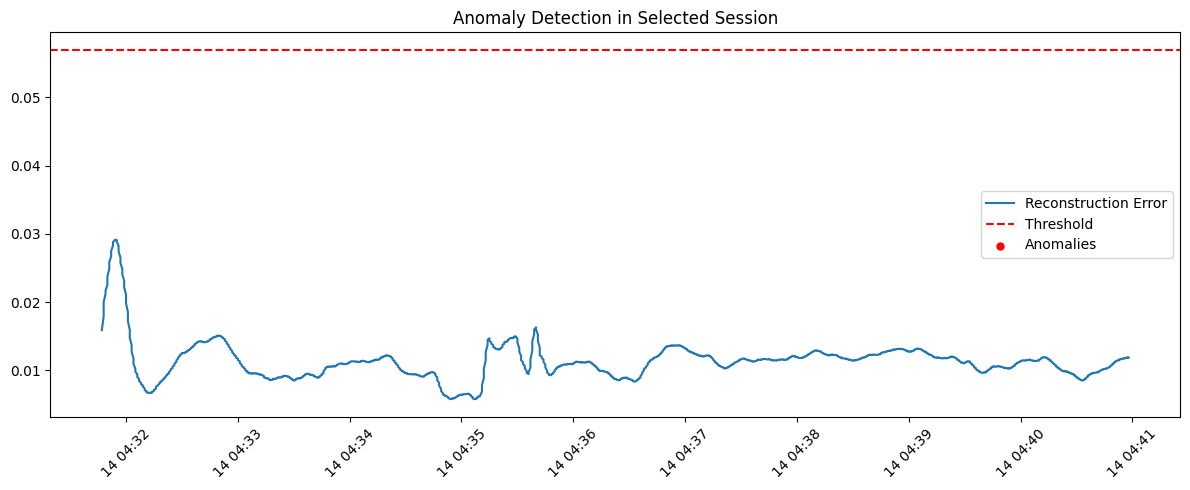

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS-1:], mae_loss, label="Reconstruction Error")
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS-1:][anomalies],
            mae_loss[anomalies], color='red', s=25, label="Anomalies")
plt.xticks(rotation=45)
plt.legend()
plt.title("Anomaly Detection in Selected Session")
plt.tight_layout()
plt.show()


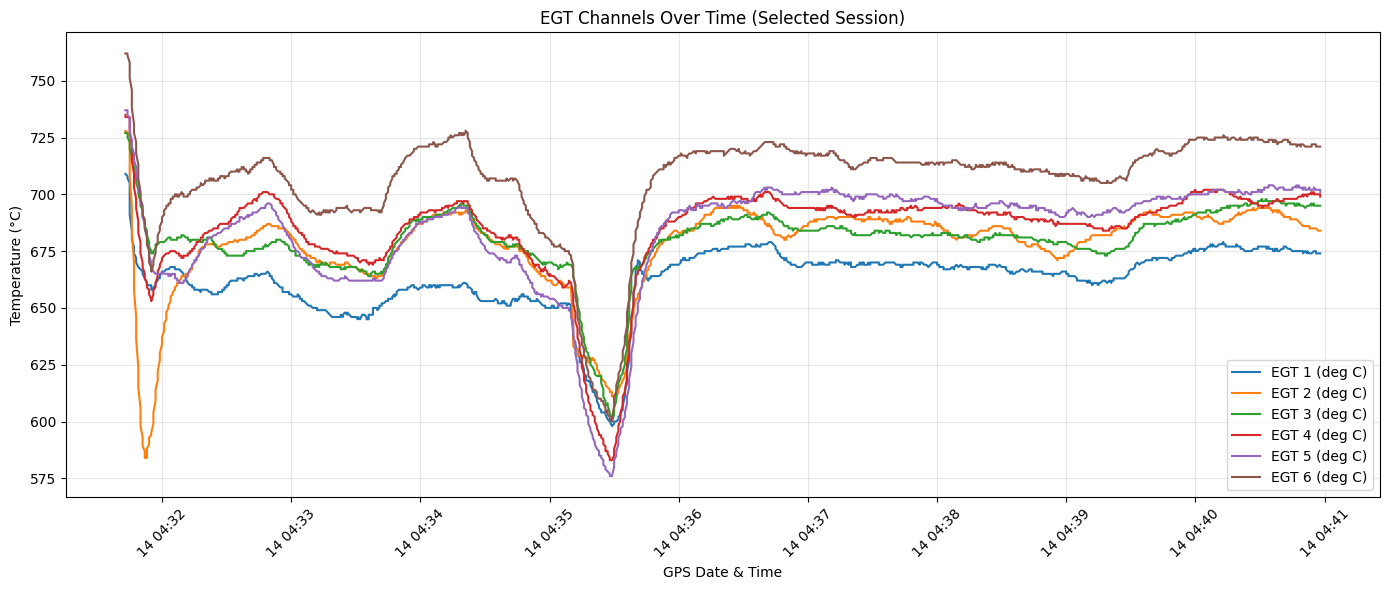

In [ ]:
import matplotlib.pyplot as plt

# List of EGT channels
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]

# Plot all EGT channels over time
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Channels Over Time (Selected Session)")
plt.xlabel("GPS Date & Time")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
start_time = pd.to_datetime('7/18/2023  3:01:30 AM')
end_time = pd.to_datetime('7/18/2023  3:20:59 AM')
session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()
print(f"Extracted session rows: {len(session_df)}")


Extracted session rows: 2341


In [ ]:
session_egt_data = session_df[egt_cols].values
session_egt_scaled = scaler.transform(session_egt_data)


In [ ]:
session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)


In [ ]:
session_pred = model.predict(session_sequences)
session_mae = np.mean(np.abs(session_sequences - session_pred), axis=(1, 2))
session_anomalies = session_mae > THRESHOLD


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


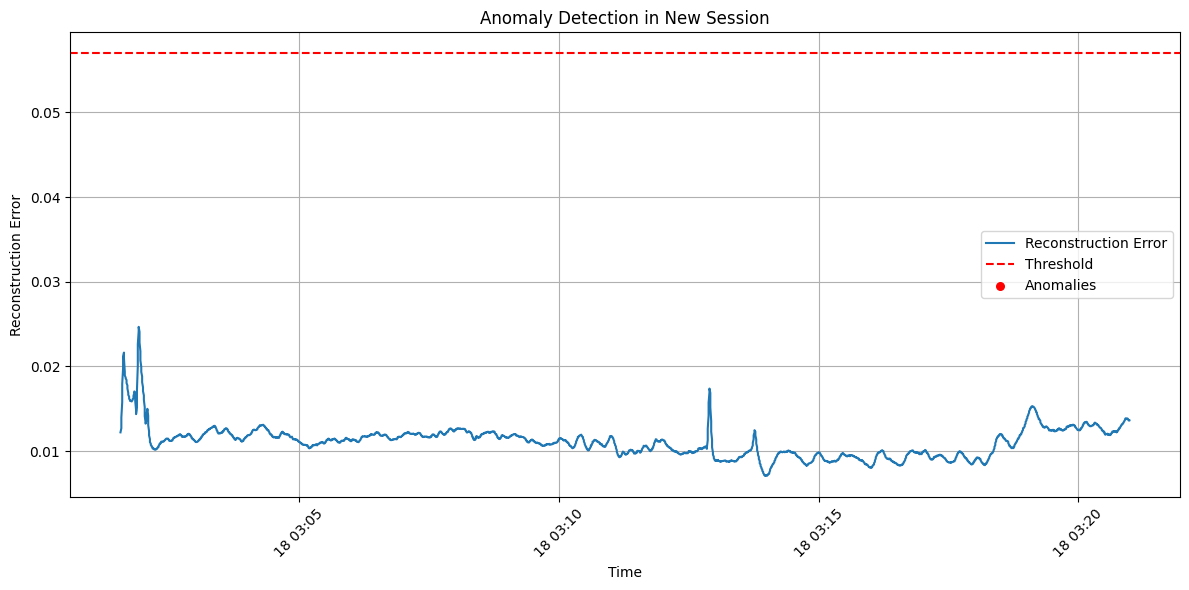

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)
plt.title('Anomaly Detection in New Session')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


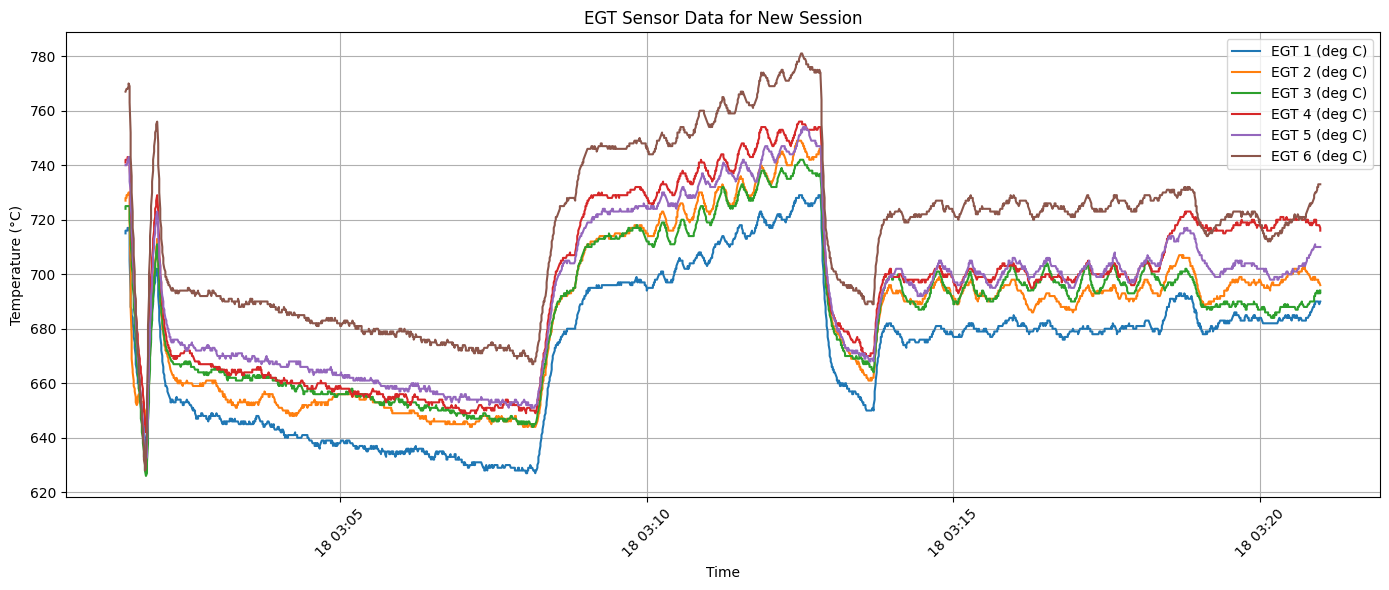

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for New Session")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
start_time = pd.to_datetime('7/18/2023 3:01:30 AM')
end_time = pd.to_datetime('7/18/2023 3:43:19 AM')

session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()
print(f"Extracted session rows: {len(session_df)}")


Extracted session rows: 5020


In [ ]:
session_egt_data = session_df[egt_cols].values
session_egt_scaled = scaler.transform(session_egt_data)


In [ ]:
session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)


In [ ]:
session_pred = model.predict(session_sequences)
session_mae = np.mean(np.abs(session_sequences - session_pred), axis=(1, 2))
session_anomalies = session_mae > THRESHOLD


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


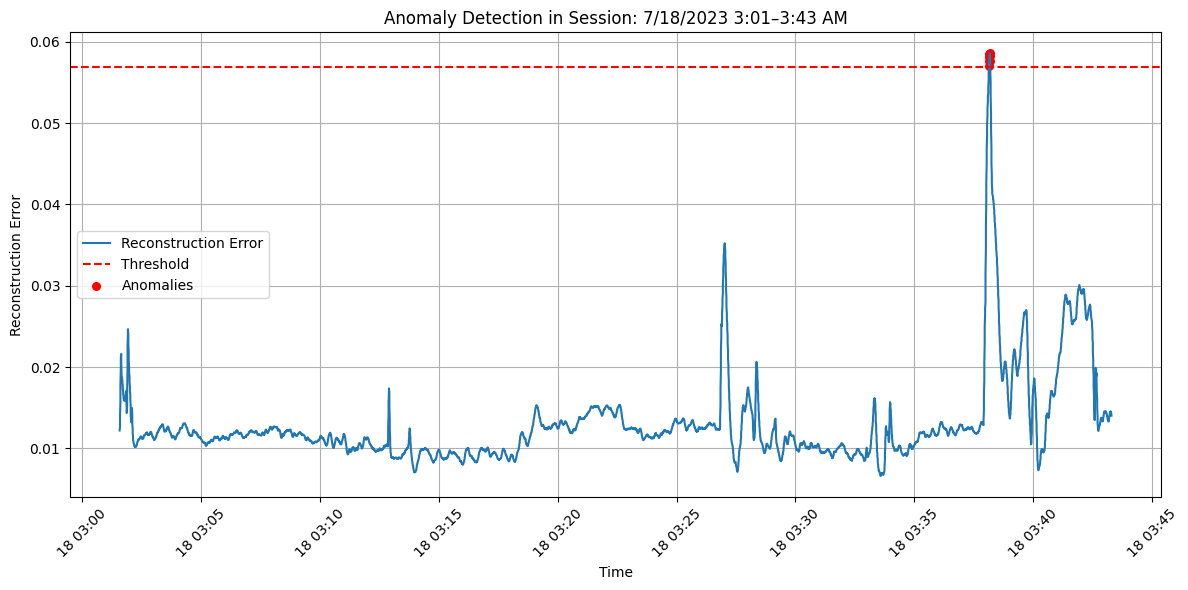

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)
plt.title('Anomaly Detection in Session: 7/18/2023 3:01–3:43 AM')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


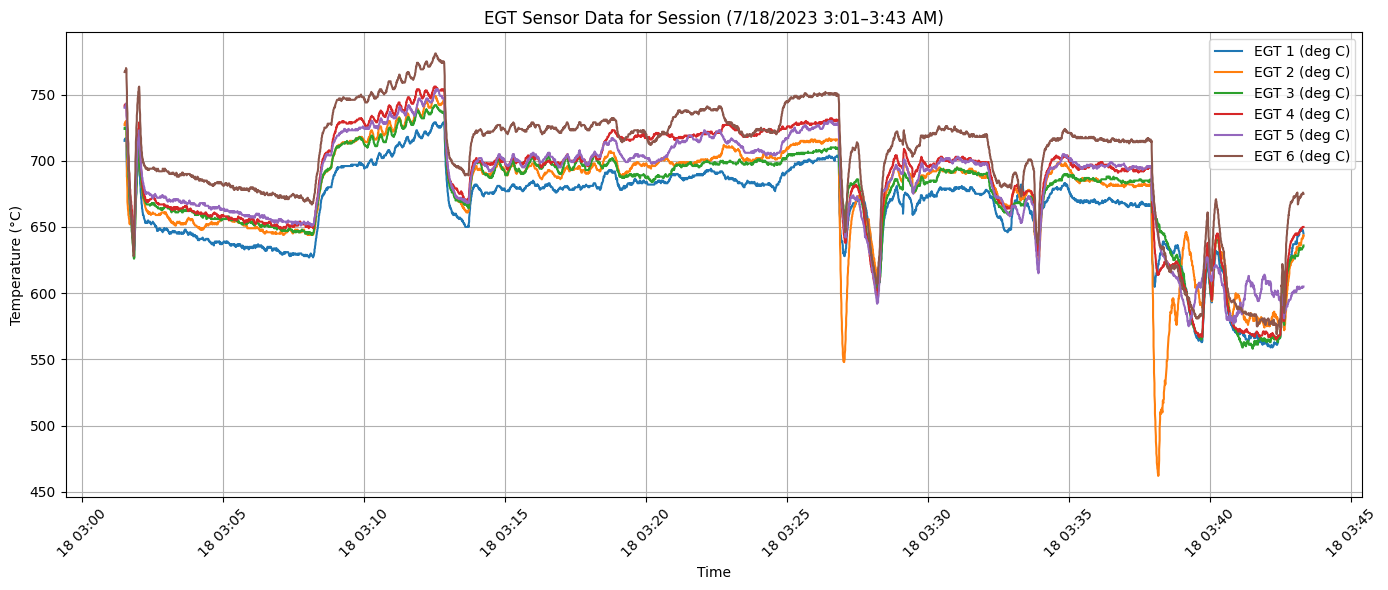

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for Session (7/18/2023 3:01–3:43 AM)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Model Prediction
session_pred = model.predict(session_sequences)
per_channel_errors = np.mean(np.abs(session_sequences - session_pred), axis=1)
session_mae = np.mean(per_channel_errors, axis=1)
session_anomalies = session_mae > THRESHOLD

# Step 2: Prepare Anomaly Attribution Info
anomaly_timestamps = []
anomaly_channels = []

for i, is_anomaly in enumerate(session_anomalies):
    if is_anomaly:
        timestamp = session_df['GPS Date & Time'].iloc[i + TIME_STEPS - 1]
        channel_idx = np.argmax(per_channel_errors[i])
        channel_name = egt_cols[channel_idx]
        anomaly_timestamps.append(timestamp)
        anomaly_channels.append(channel_name)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


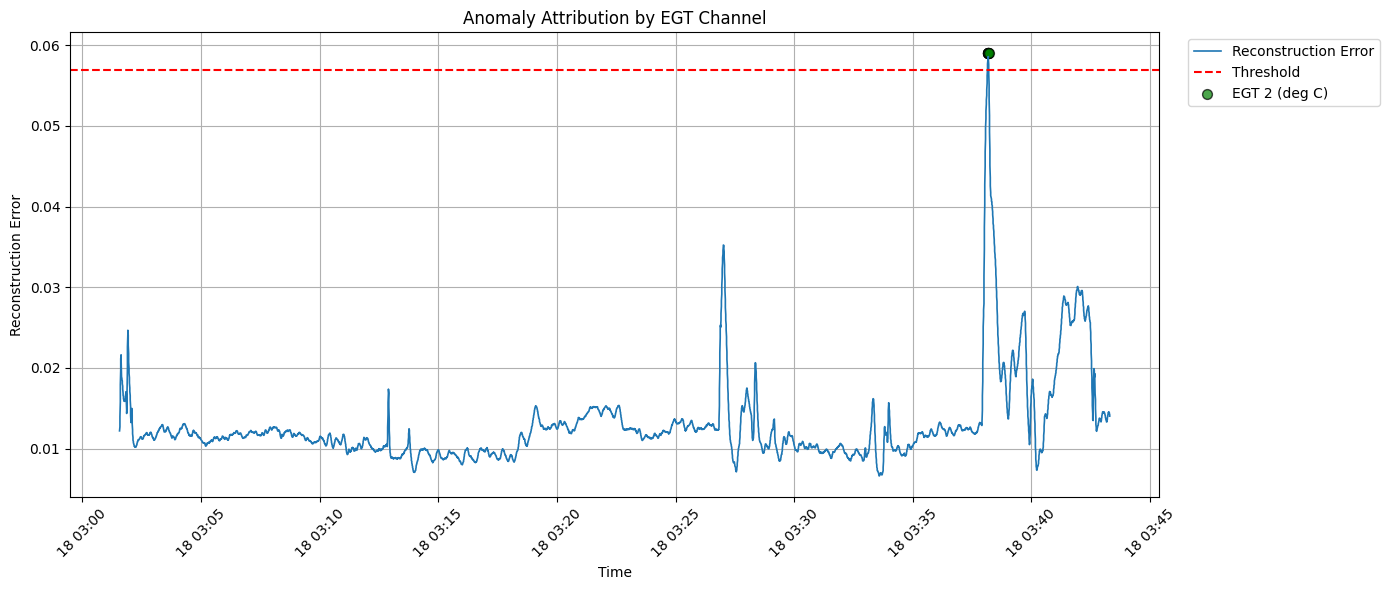

In [ ]:
# Assign a color to each EGT
colors = {
    'EGT 1 (deg C)': 'blue',
    'EGT 2 (deg C)': 'green',
    'EGT 3 (deg C)': 'orange',
    'EGT 4 (deg C)': 'purple',
    'EGT 5 (deg C)': 'brown',
    'EGT 6 (deg C)': 'pink'
}

# Plot the reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error', linewidth=1.2)
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')

# Overlay anomalies, color-coded by channel
for t, ch in zip(anomaly_timestamps, anomaly_channels):
    plt.scatter(t, THRESHOLD + 0.002, color=colors[ch], label=ch, s=50, alpha=0.7, edgecolor='k')

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.title('Anomaly Attribution by EGT Channel')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Define your new session time range
start_time = pd.to_datetime('7/18/2023 4:56:01 AM')
end_time = pd.to_datetime('7/18/2023 6:00:00 AM')

# Filter the session
session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()

print(f" Extracted session rows: {len(session_df)}")

 Extracted session rows: 7681


In [ ]:
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
session_egt_data = session_df[egt_cols].dropna().values

# Scale using your preloaded scaler
session_egt_scaled = scaler.transform(session_egt_data)


In [ ]:
def create_sequences(data, time_steps):
    return np.array([data[i:i + time_steps] for i in range(len(data) - time_steps + 1)])

session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)


In [ ]:
session_pred = model.predict(session_sequences)
session_mae = np.mean(np.abs(session_sequences - session_pred), axis=(1, 2))
session_anomalies = session_mae > THRESHOLD


240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


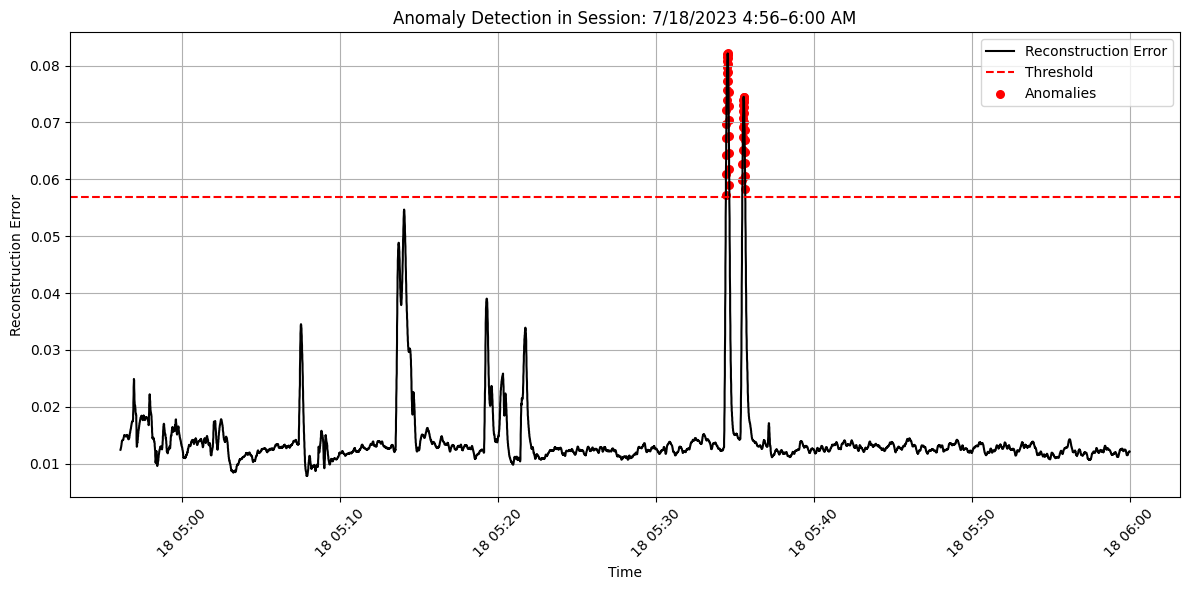

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error', color='black')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)
plt.title('Anomaly Detection in Session: 7/18/2023 4:56–6:00 AM')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


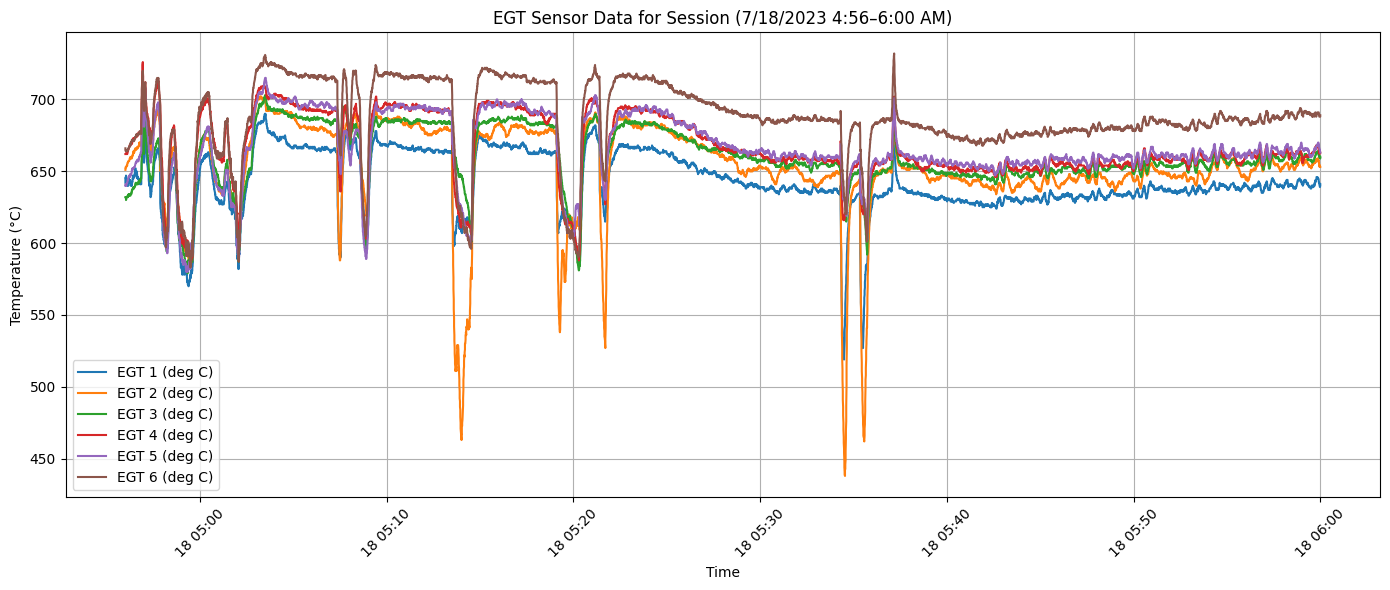

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for Session (7/18/2023 4:56–6:00 AM)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load full dataset
df = pd.read_csv("2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv")

# Convert GPS timestamp
df['GPS Date & Time'] = pd.to_datetime(df['GPS Date & Time'], errors='coerce')

# Drop rows with missing timestamps or EGTs
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
df.dropna(subset=['GPS Date & Time'] + egt_cols, inplace=True)


In [ ]:
# Make sure your 'scaler' is loaded again from pickle
egt_data = df[egt_cols].values
egt_scaled = scaler.transform(egt_data)


In [ ]:
def create_sequences(data, time_steps):
    return np.array([data[i:i+time_steps] for i in range(len(data) - time_steps + 1)])

X_full = create_sequences(egt_scaled, TIME_STEPS)


In [ ]:
X_pred = model.predict(X_full)
full_mae = np.mean(np.abs(X_full - X_pred), axis=(1, 2))
full_anomalies = full_mae > THRESHOLD


3732/3732 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step


In [ ]:
results_df = df.iloc[TIME_STEPS - 1:].copy()
results_df['MAE_Loss'] = full_mae
results_df['Is_Anomaly'] = full_anomalies


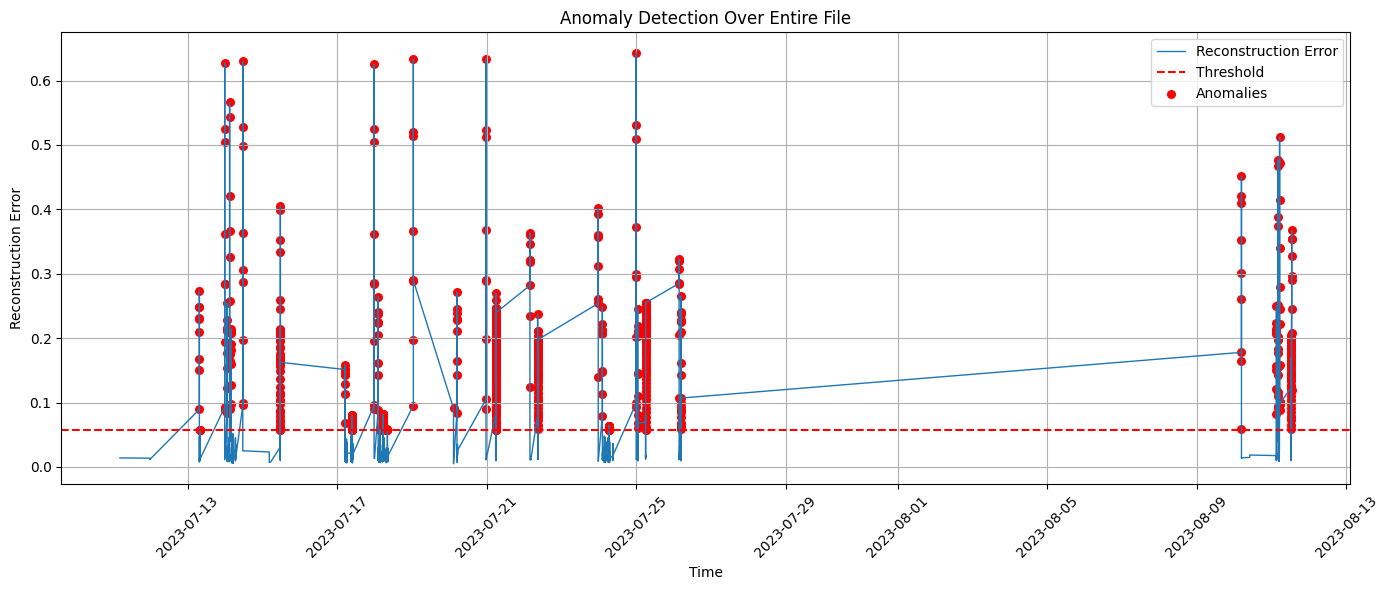

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(results_df['GPS Date & Time'], full_mae, label='Reconstruction Error', linewidth=1)
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')

# Mark anomalies
plt.scatter(results_df['GPS Date & Time'][full_anomalies],
            full_mae[full_anomalies], color='red', s=30, label='Anomalies')

plt.title('Anomaly Detection Over Entire File')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
total_anomalies = results_df['Is_Anomaly'].sum()
print(f"Total anomalies detected in the dataset: {total_anomalies}")


Total anomalies detected in the dataset: 740


In [ ]:
# Load full CSV
df = pd.read_csv("2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv")

# Convert GPS Date & Time column
df['GPS Date & Time'] = pd.to_datetime(df['GPS Date & Time'], errors='coerce')

# Filter session
start_time = pd.to_datetime('7/24/2023  3:09:22 AM')
end_time = pd.to_datetime('7/24/2023  4:37:27 AM')

session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()
print(f"Session rows: {len(session_df)}")

# Define EGT columns
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
session_egt_data = session_df[egt_cols].dropna().values


Session rows: 10573


In [ ]:
# Prepare session data
session_egt_data = session_df[egt_cols].dropna().values
session_egt_scaled = scaler.transform(session_egt_data)

# Create sequences
def create_sequences(data, time_steps):
    return np.array([data[i:i + time_steps] for i in range(len(data) - time_steps + 1)])

session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)


In [ ]:
# Model prediction
session_pred = model.predict(session_sequences)

# Reconstruction error
session_mae = np.mean(np.abs(session_sequences - session_pred), axis=(1, 2))
session_anomalies = session_mae > THRESHOLD


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


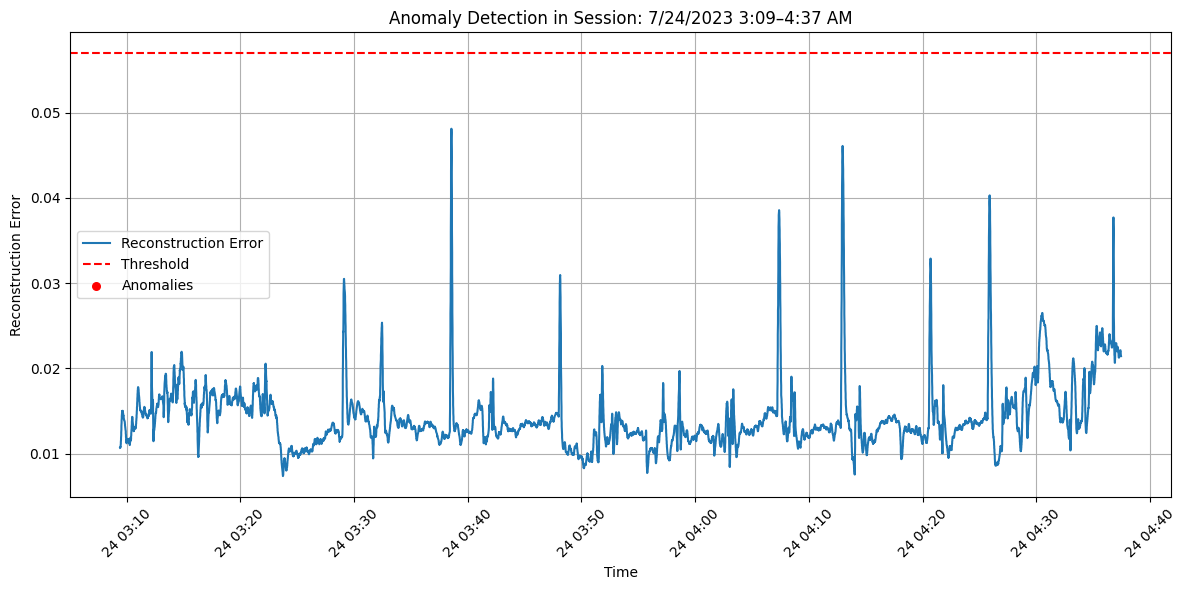

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)

plt.title('Anomaly Detection in Session: 7/24/2023 3:09–4:37 AM')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


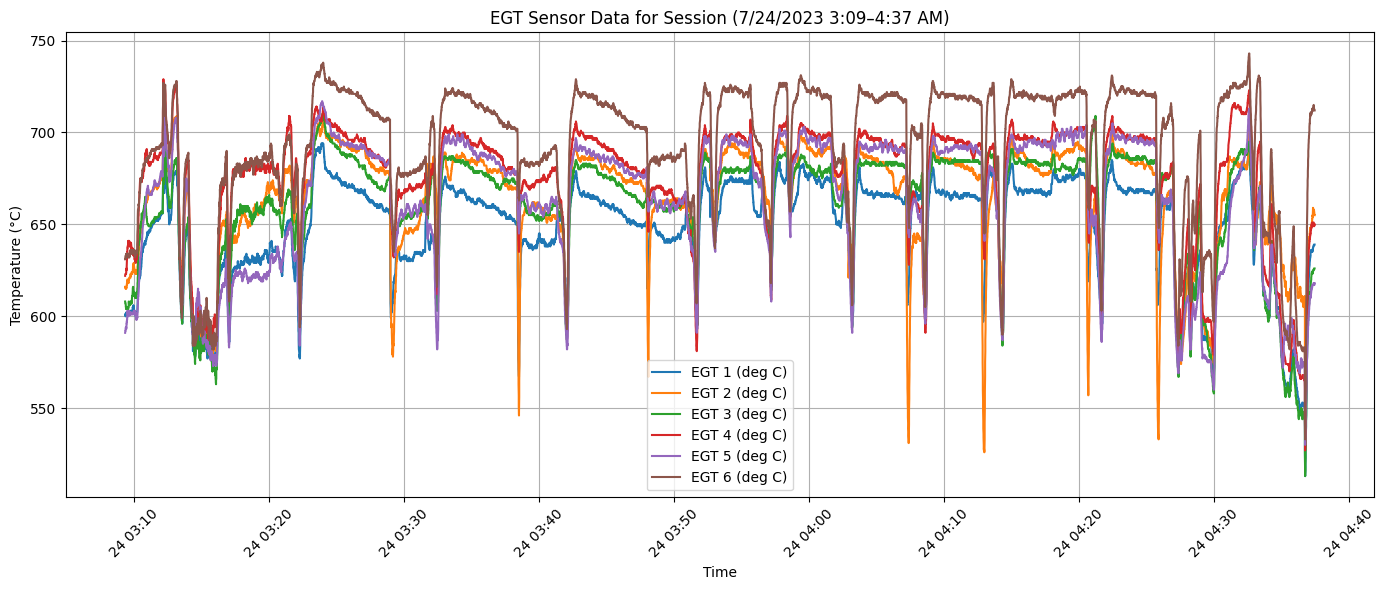

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for Session (7/24/2023 3:09–4:37 AM)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Detailed per-channel errors
per_channel_errors = np.mean(np.abs(session_sequences - session_pred), axis=1)
session_mae = np.mean(per_channel_errors, axis=1)
session_anomalies = session_mae > THRESHOLD

# Attribution: Which channel caused anomaly?
anomaly_timestamps = []
anomaly_channels = []

for i, is_anomaly in enumerate(session_anomalies):
    if is_anomaly:
        timestamp = session_df['GPS Date & Time'].iloc[i + TIME_STEPS - 1]
        channel_idx = np.argmax(per_channel_errors[i])
        channel_name = egt_cols[channel_idx]
        anomaly_timestamps.append(timestamp)
        anomaly_channels.append(channel_name)


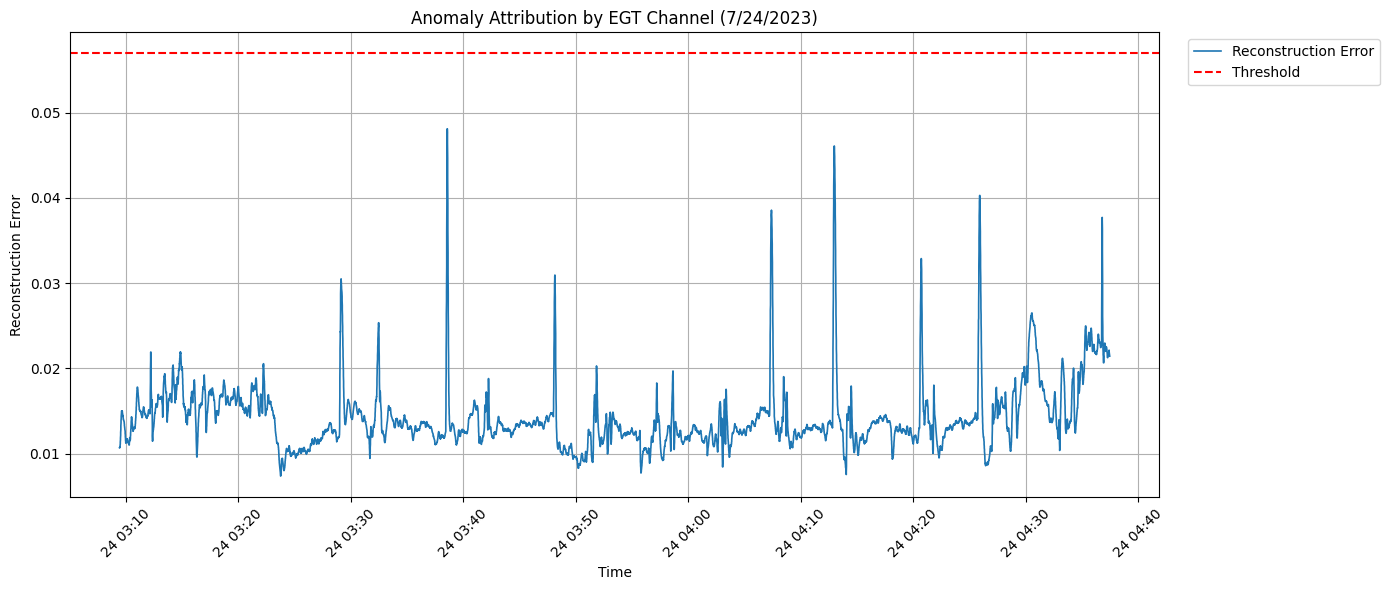

In [ ]:
# Assign a color to each EGT
colors = {
    'EGT 1 (deg C)': 'blue',
    'EGT 2 (deg C)': 'green',
    'EGT 3 (deg C)': 'orange',
    'EGT 4 (deg C)': 'purple',
    'EGT 5 (deg C)': 'brown',
    'EGT 6 (deg C)': 'pink'
}

# Plot
plt.figure(figsize=(14, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error', linewidth=1.2)
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')

# Overlay anomalies
for t, ch in zip(anomaly_timestamps, anomaly_channels):
    plt.scatter(t, THRESHOLD + 0.002, color=colors[ch], label=ch, s=50, alpha=0.7, edgecolor='k')

# Remove duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.title('Anomaly Attribution by EGT Channel (7/24/2023)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the dataset (if not already loaded)
df = pd.read_csv("2023-08-11-SMK504-SN8601-15.3.3.4688-USER_LOG_DATA.csv")
df['GPS Date & Time'] = pd.to_datetime(df['GPS Date & Time'], errors='coerce')

# Define new session time
start_time = pd.to_datetime('7/17/2023  4:58:16 AM')
end_time = pd.to_datetime('7/17/2023  11:53:00 PM')

# Filter session
session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()
print(f"Session rows: {len(session_df)}")


Session rows: 19923


In [ ]:
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
session_df.dropna(subset=egt_cols, inplace=True)
session_egt_data = session_df[egt_cols].values
session_egt_scaled = scaler.transform(session_egt_data)


In [ ]:
def create_sequences(data, time_steps):
    return np.array([data[i:i + time_steps] for i in range(len(data) - time_steps + 1)])

session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)
session_pred = model.predict(session_sequences, verbose=0)


In [ ]:
import numpy as np

per_channel_errors = np.mean(np.abs(session_sequences - session_pred), axis=1)
session_mae = np.mean(per_channel_errors, axis=1)
session_anomalies = session_mae > THRESHOLD


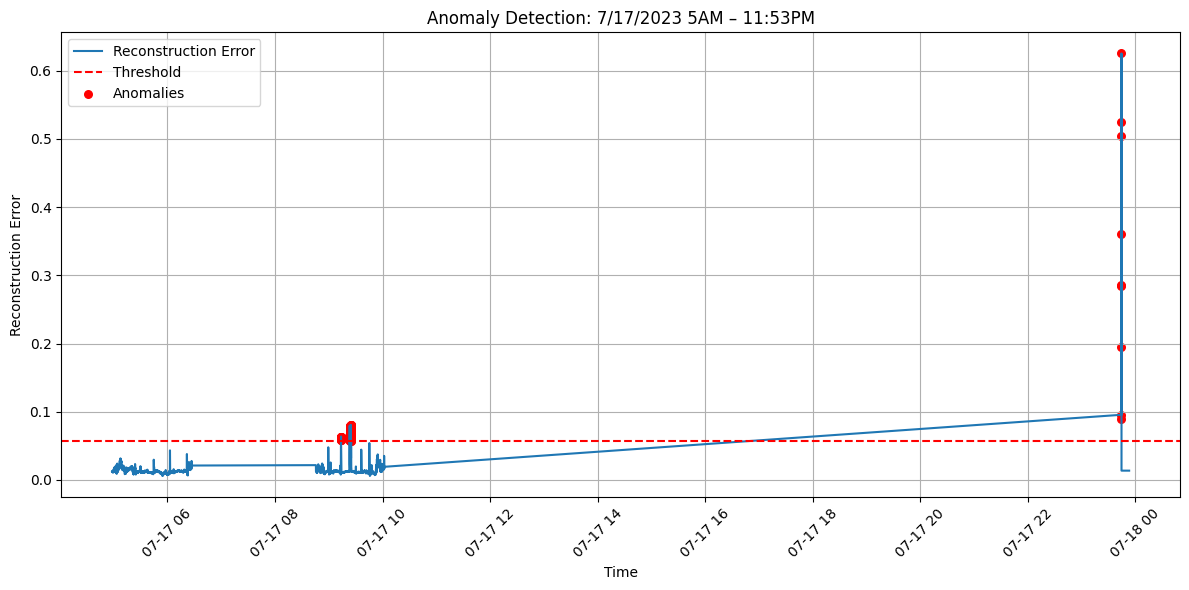

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)
plt.title('Anomaly Detection: 7/17/2023 5AM – 11:53PM')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


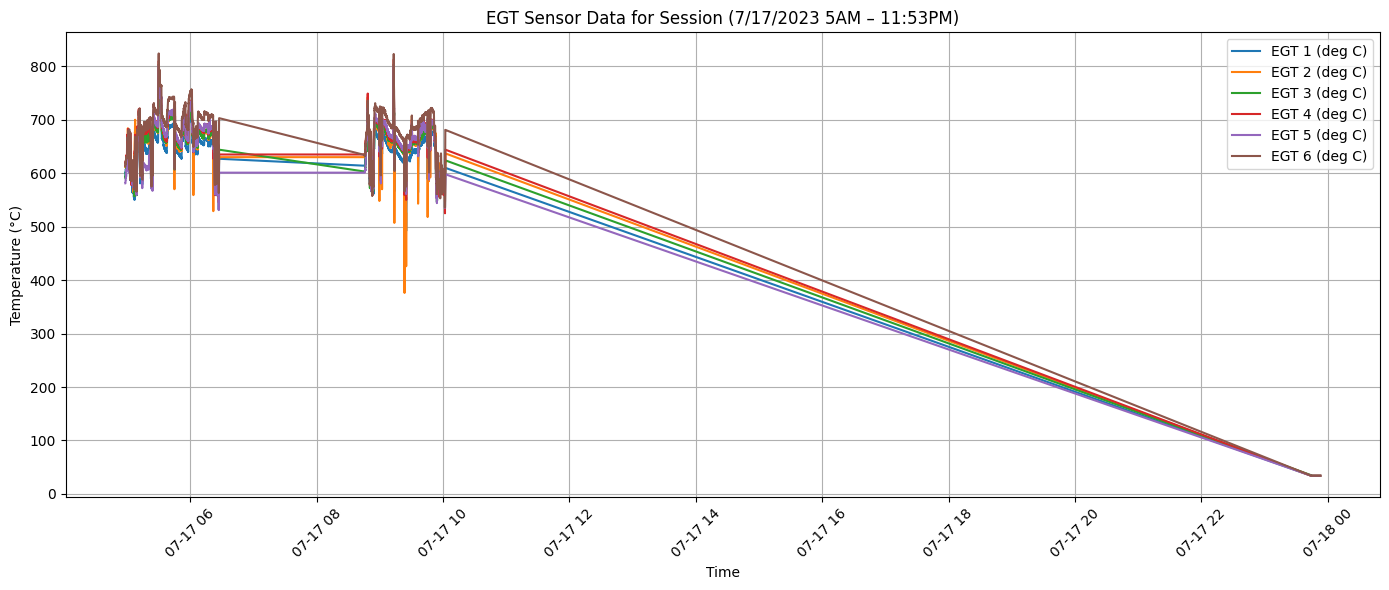

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for Session (7/17/2023 5AM – 11:53PM)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Assign anomaly to channel
anomaly_timestamps = []
anomaly_channels = []

for i, is_anomaly in enumerate(session_anomalies):
    if is_anomaly:
        timestamp = session_df['GPS Date & Time'].iloc[i + TIME_STEPS - 1]
        channel_idx = np.argmax(per_channel_errors[i])
        channel_name = egt_cols[channel_idx]
        anomaly_timestamps.append(timestamp)
        anomaly_channels.append(channel_name)


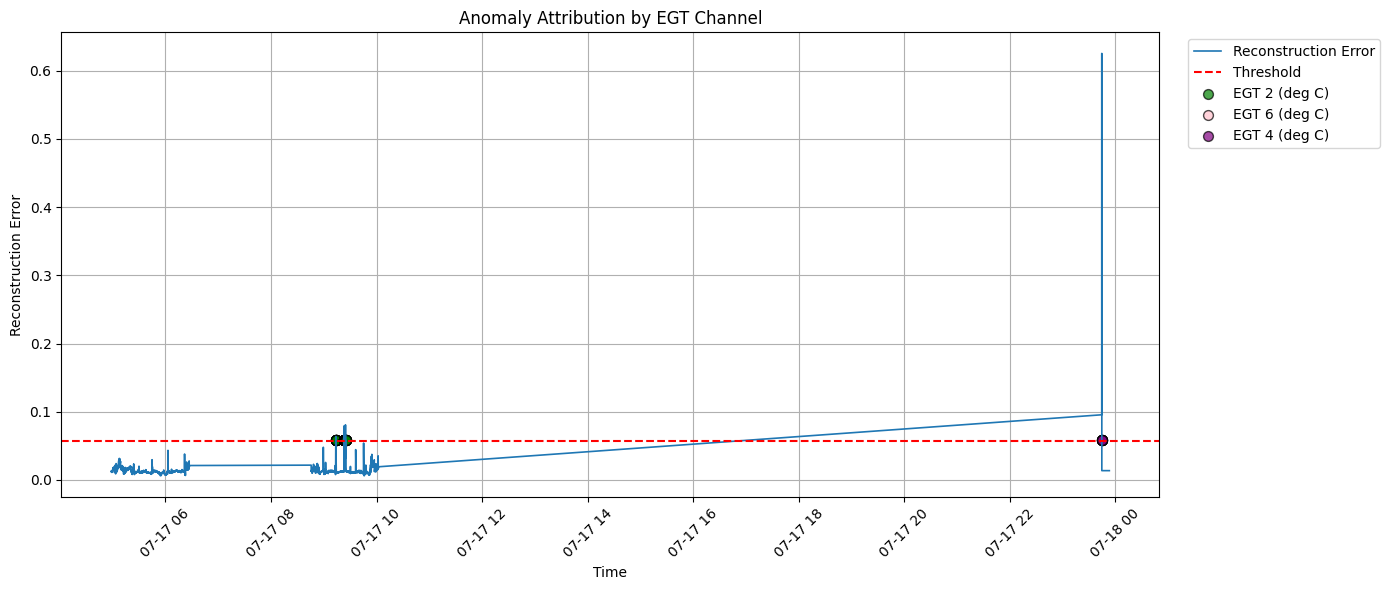

In [ ]:
colors = {
    'EGT 1 (deg C)': 'blue',
    'EGT 2 (deg C)': 'green',
    'EGT 3 (deg C)': 'orange',
    'EGT 4 (deg C)': 'purple',
    'EGT 5 (deg C)': 'brown',
    'EGT 6 (deg C)': 'pink'
}

plt.figure(figsize=(14, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error', linewidth=1.2)
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')

for t, ch in zip(anomaly_timestamps, anomaly_channels):
    plt.scatter(t, THRESHOLD + 0.002, color=colors[ch], label=ch, s=50, alpha=0.7, edgecolor='k')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title('Anomaly Attribution by EGT Channel')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


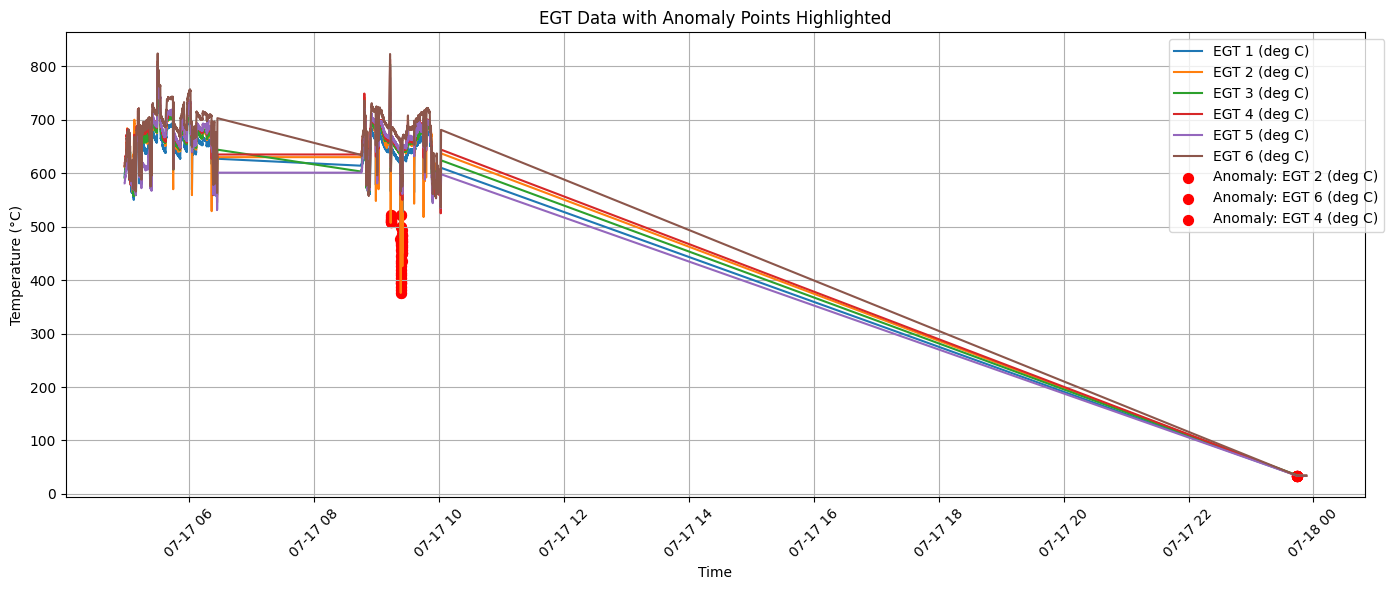

In [ ]:
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

# Overlay anomalies
for t, ch in zip(anomaly_timestamps, anomaly_channels):
    plt.scatter(t, session_df.loc[session_df['GPS Date & Time'] == t, ch].values[0],
                color='red', s=50, label=f'Anomaly: {ch}')

# Clean legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1))
plt.title("EGT Data with Anomaly Points Highlighted")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Define your new session time range
start_time = pd.to_datetime('7/18/2023 4:56:01 AM')
end_time = pd.to_datetime('7/18/2023 6:00:00 AM')

# Filter the session
session_df = df[(df['GPS Date & Time'] >= start_time) & (df['GPS Date & Time'] <= end_time)].copy()

print(f" Extracted session rows: {len(session_df)}")
egt_cols = [f'EGT {i} (deg C)' for i in range(1, 7)]
session_egt_data = session_df[egt_cols].dropna().values

# Scale using your preloaded scaler
session_egt_scaled = scaler.transform(session_egt_data)
def create_sequences(data, time_steps):
    return np.array([data[i:i + time_steps] for i in range(len(data) - time_steps + 1)])

session_sequences = create_sequences(session_egt_scaled, TIME_STEPS)
session_pred = model.predict(session_sequences)
session_mae = np.mean(np.abs(session_sequences - session_pred), axis=(1, 2))
session_anomalies = session_mae > THRESHOLD
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(session_df['GPS Date & Time'][TIME_STEPS - 1:], session_mae, label='Reconstruction Error', color='black')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.scatter(session_df['GPS Date & Time'][TIME_STEPS - 1:][session_anomalies],
            session_mae[session_anomalies], color='red', label='Anomalies', s=30)
plt.title('Anomaly Detection in Session: 7/18/2023 4:56–6:00 AM')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))
for col in egt_cols:
    plt.plot(session_df['GPS Date & Time'], session_df[col], label=col)

plt.title("EGT Sensor Data for Session (7/18/2023 4:56–6:00 AM)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined